<h1>Load Dataset and Setup</h1>

In [1]:
import torch
torch.set_num_threads(4)           
torch.set_num_interop_threads(4)

import pandas as pd
import json
import os


csv_path = os.path.join('../data', 'spotify_dataset.csv')
json1_path = os.path.join('../data', '900k Definitive Spotify Dataset.json')
json2_path = os.path.join('../data', 'final_milliondataset_BERT_500K_revised.json')

try:
    df_csv = pd.read_csv(csv_path, low_memory=False)
    print(f"CSV loaded with {len(df_csv)} rows and {len(df_csv.columns)} columns\n")
except Exception as e:
    print(f"Error loading CSV: {e}")

print("CSV dataset info:")
display(df_csv.info())
print("\nCSV dataset sample:")
display(df_csv.head())

print("\nLoading first JSON dataset sample (first 1000 records)...")
try:
    with open(json1_path, 'r', encoding='utf-8') as f:
        data_json1 = []
        for i, line in enumerate(f):
            if i >= 1000:
                break
            data_json1.append(json.loads(line))
    print(f"Loaded {len(data_json1)} JSON records from first file\n")
except Exception as e:
    print(f"Error loading JSON 1: {e}")

if len(data_json1) > 0:
    print("Keys in one JSON record:")
    display(data_json1[0].keys())
    print("\nSample JSON record:")
    display(data_json1[0])

try:
    with open(json2_path, 'r', encoding='utf-8') as f:
        data_json2 = []
        for i, line in enumerate(f):
            if i >= 1000:
                break
            data_json2.append(json.loads(line))
    print(f"Loaded {len(data_json2)} JSON records from first file\n")
except Exception as e:
    print(f"Error loading JSON 1: {e}")

if len(data_json2) > 0:
    print("Keys in one JSON record:")
    display(data_json2[0].keys())
    print("\nSample JSON record:")
    display(data_json2[0])

CSV loaded with 551443 rows and 39 columns

CSV dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551443 entries, 0 to 551442
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Artist(s)                       551443 non-null  object 
 1   song                            551427 non-null  object 
 2   text                            551443 non-null  object 
 3   Length                          551443 non-null  object 
 4   emotion                         551443 non-null  object 
 5   Genre                           551443 non-null  object 
 6   Album                           551391 non-null  object 
 7   Release Date                    551443 non-null  object 
 8   Key                             551443 non-null  object 
 9   Tempo                           551443 non-null  int64  
 10  Loudness (db)                   551443 non-null  object 
 11  Time signature  

None


CSV dataset sample:


,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,03:47,sadness,hip hop,Thr!!!er,29th April 2013,D min,105,...,0,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",04:03,sadness,hip hop,Thr!!!er,29th April 2013,A# min,117,...,0,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",05:51,joy,hip hop,Louden Up Now,8th June 2004,A Maj,121,...,0,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752
3,!!!,Ooo,[Verse 1] Remember when I called you on the te...,03:44,joy,hip hop,As If,16th October 2015,A min,122,...,0,Eric Clapton,Man Overboard,0.992749,Roxette,Don't Believe In Accidents,0.991494,Tiwa Savage,My Darlin,0.990381
4,!!!,Freedom 15,[Verse 1] Calling me like I got something to s...,06:00,joy,hip hop,As If,16th October 2015,F min,123,...,0,Cibo Matto,Lint Of Love,0.981610,Barrington Levy,Better Than Gold,0.981524,Freestyle,Its Automatic,0.981415



Loading first JSON dataset sample (first 1000 records)...
Loaded 1000 JSON records from first file

Keys in one JSON record:


dict_keys(['Artist(s)', 'song', 'text', 'Length', 'emotion', 'Genre', 'Album', 'Release Date', 'Key', 'Tempo', 'Loudness (db)', 'Time signature', 'Explicit', 'Popularity', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Liveness', 'Acousticness', 'Instrumentalness', 'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation', 'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine', 'Similar Songs'])


Sample JSON record:


{'Artist(s)': '!!!',
 'song': 'Even When the Waters Cold',
 'text': 'Friends told her she was better off at the bottom of a river Than in a bed with him He said "Until you try both, you won\'t know what you like better Why don\'t we go for a swim?" Well, friends told her this and friends told her that But friends don\'t choose what echoes in your head When she got bored with all the idle chit-and-chat Kept thinking \'bout what he said I\'ll swim even when the water\'s cold That\'s the one thing that I know Even when the water\'s cold She remembers it fondly, she doesn\'t remember it all But what she does, she sees clearly She lost his number, and he never called But all she really lost was an earring The other\'s in a box with others she has lost I wonder if she still hears me I\'ll swim even when the water\'s cold That\'s the one thing that I know Even when the water\'s cold If you believe in love You know that sometimes it isn\'t Do you believe in love? Then save the bullshit questio

Loaded 1000 JSON records from first file

Keys in one JSON record:


dict_keys(['Artist(s)', 'song', 'text', 'Length', 'emotion', 'ISRC', 'Genre', 'Album', 'Release Date', 'Key', 'Tempo', 'Loudness (db)', 'Time signature', 'Song Number', 'Explicit', 'Popularity', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Liveness', 'Acousticness', 'Instrumentalness', 'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation', 'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine', 'Similar Songs'])


Sample JSON record:


{'Artist(s)': '!!!',
 'song': 'Even When the Waters Cold',
 'text': 'Friends told her she was better off at the bottom of a river\nThan in a bed with him\nHe said "Until you try both, you won\'t know what you like better\nWhy don\'t we go for a swim?"\nWell, friends told her this and friends told her that\nBut friends don\'t choose what echoes in your head\nWhen she got bored with all the idle chit-and-chat\nKept thinking \'bout what he said\n\nI\'ll swim even when the water\'s cold\nThat\'s the one thing that I know\nEven when the water\'s cold\n\nShe remembers it fondly, she doesn\'t remember it all\nBut what she does, she sees clearly\nShe lost his number, and he never called\nBut all she really lost was an earring\nThe other\'s in a box with others she has lost\nI wonder if she still hears me\n\nI\'ll swim even when the water\'s cold\nThat\'s the one thing that I know\nEven when the water\'s cold\nIf you believe in love\nYou know that sometimes it isn\'t\nDo you believe in love?\nT

In [2]:
# For BERT
import sys
print(sys.executable)
print(torch.cuda.is_available())

/home/jack/Desktop/spotify-lyrical-analysis/venv/bin/python
True


<h1>Dataset Cleaning and Preprocessing</h1>

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Merged dataset size: (553443, 16)
emotion
joy        189655
sadness    157185
anger       96062
Name: count, dtype: int64
After cleaning:


,text,emotion,genre,key,tempo,loudness_db,time_signature,explicit,popularity,energy,danceability,positiveness,speechiness,liveness,acousticness,instrumentalness
0,Friends told her she was better off at the bot...,sadness,hip hop,D min,105.0,-6.85,4/4,0,40,83,71,87,4,16,11,0
1,"Well I heard it, playing soft From a drunken b...",sadness,hip hop,A# min,117.0,-5.75,4/4,0,42,85,70,87,4,32,0,0
2,"Oh my god, did I just say that out loud? Shoul...",joy,hip hop,A Maj,121.0,-6.06,4/4,0,29,89,71,63,8,64,0,20
3,[Verse 1] Remember when I called you on the te...,joy,hip hop,A min,122.0,-5.42,4/4,0,24,84,78,97,4,12,12,0
4,[Verse 1] Calling me like I got something to s...,joy,hip hop,F min,123.0,-5.57,4/4,0,30,71,77,70,7,10,4,1


,tempo,loudness_db,explicit,popularity,energy,danceability,positiveness,speechiness,liveness,acousticness,instrumentalness
count,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000,442902.000000
mean,120.660059,-8.048557,0.289604,30.479449,63.026198,58.490005,47.103585,11.620234,19.847761,25.665529,7.304526
std,29.756910,4.006575,0.453579,17.206086,22.559058,17.384143,24.059627,12.415717,16.338213,29.382087,20.674488
min,0.201183,-50.060000,0.000000,0.000000,0.000000,6.000000,0.000000,2.000000,1.000000,0.000000,0.000000
25%,97.000000,-9.870000,0.000000,18.000000,48.000000,47.000000,28.000000,4.000000,10.000000,2.000000,0.000000
50%,120.000000,-7.210000,0.000000,28.000000,65.000000,59.000000,46.000000,6.000000,13.000000,12.000000,0.000000
75%,140.000000,-5.360000,1.000000,40.000000,81.000000,72.000000,66.000000,15.000000,25.000000,43.000000,0.000000
max,200.000000,4.980000,1.000000,100.000000,100.000000,99.000000,100.000000,97.000000,100.000000,100.000000,100.000000


emotion
joy        189655
sadness    157185
anger       96062
Name: count, dtype: int64
genre
hip hop                             188207
pop                                   8982
country                               6458
folk                                  4318
jazz                                  3306
rap,hip hop                           3118
rock,pop,alternative rock             3117
soul                                  3093
hip hop,trap                          3085
rock                                  3047
rap,hip hop,trap                      2789
trap                                  2696
rock,heavy metal,metal                2469
rock,alternative rock,indie rock      2355
reggae                                2339
rock,alternative rock,punk            2141
indie rock                            2093
rap,hip-hop,hip hop                   1955
indie pop                             1683
punk                                  1592
Name: count, dtype: int64


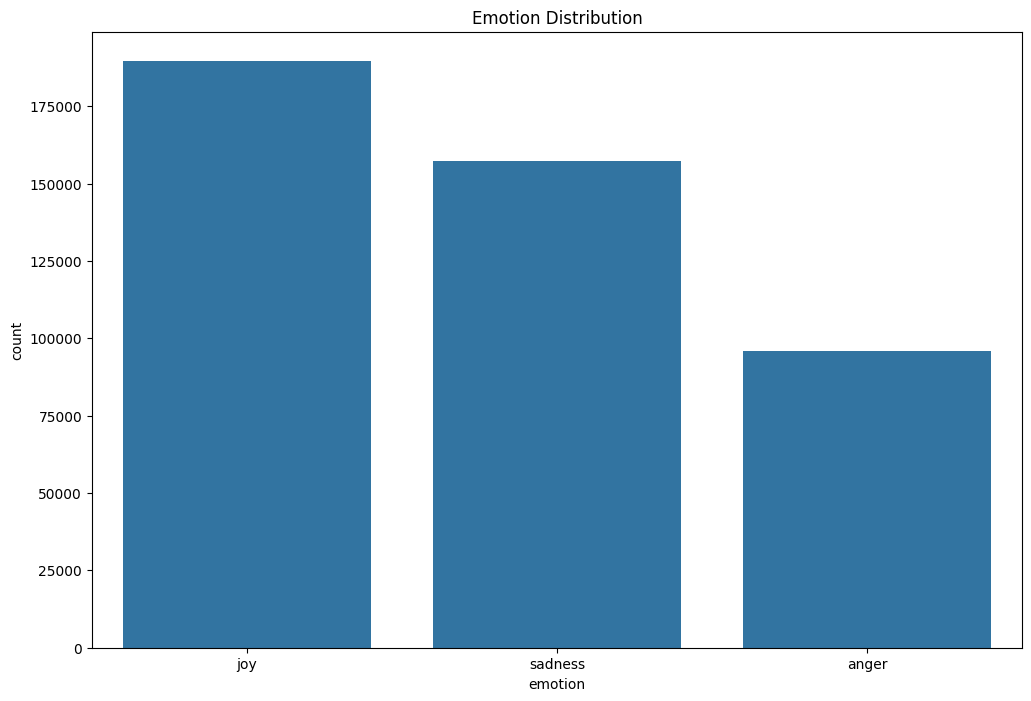

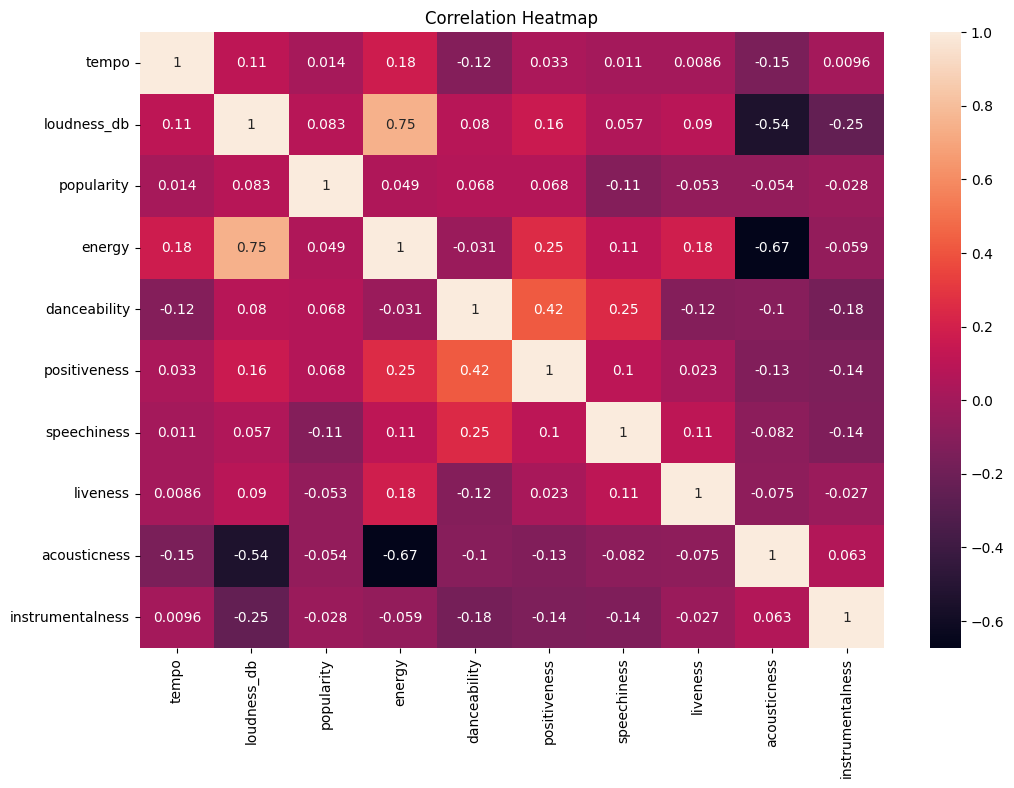

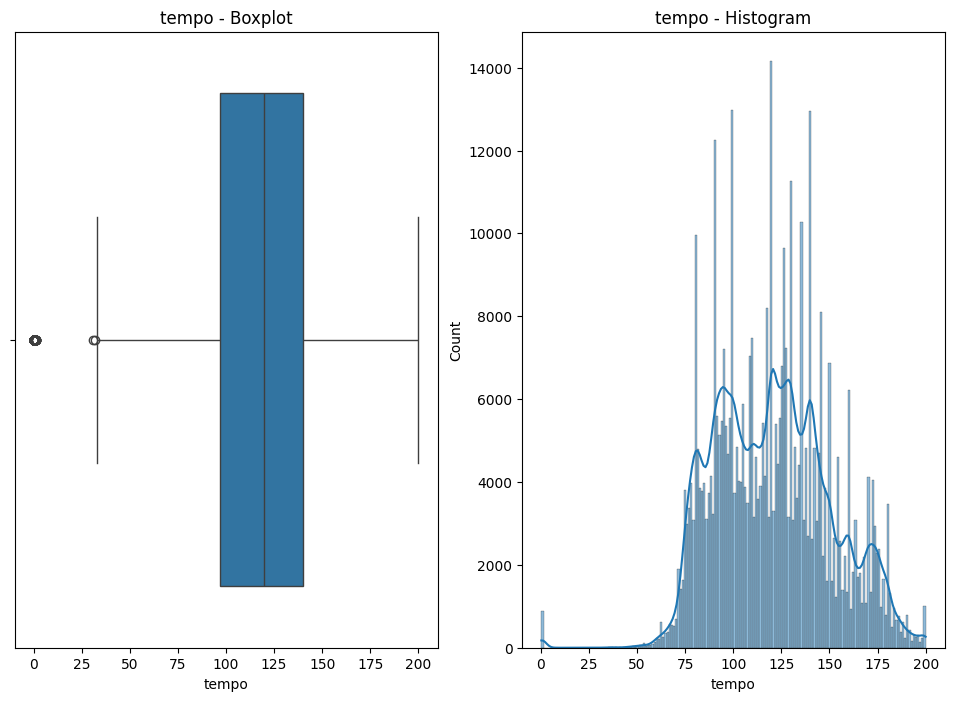

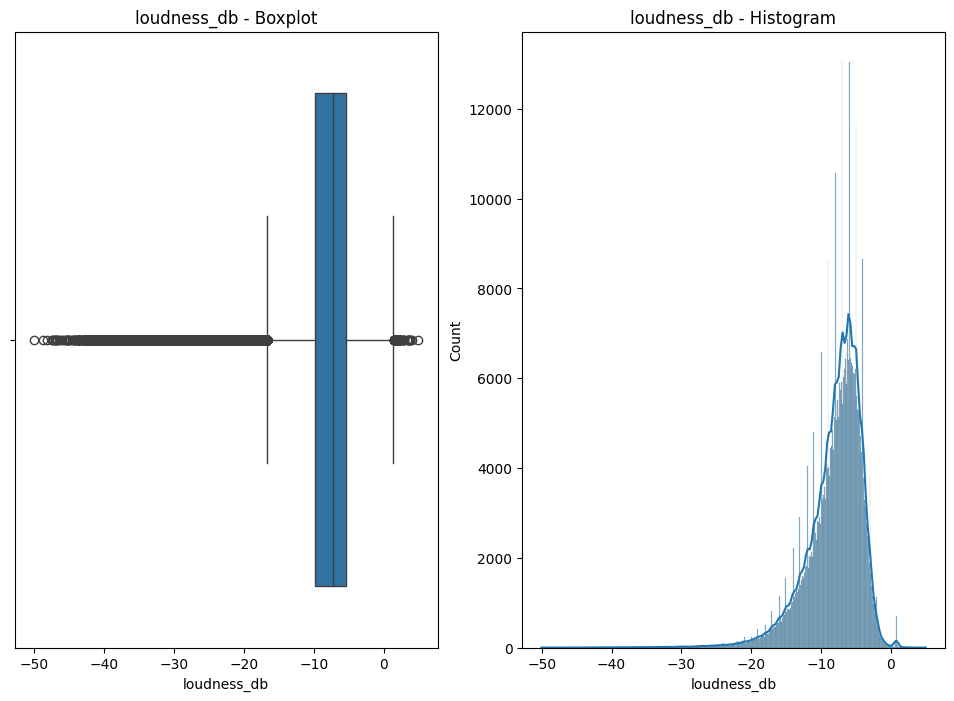

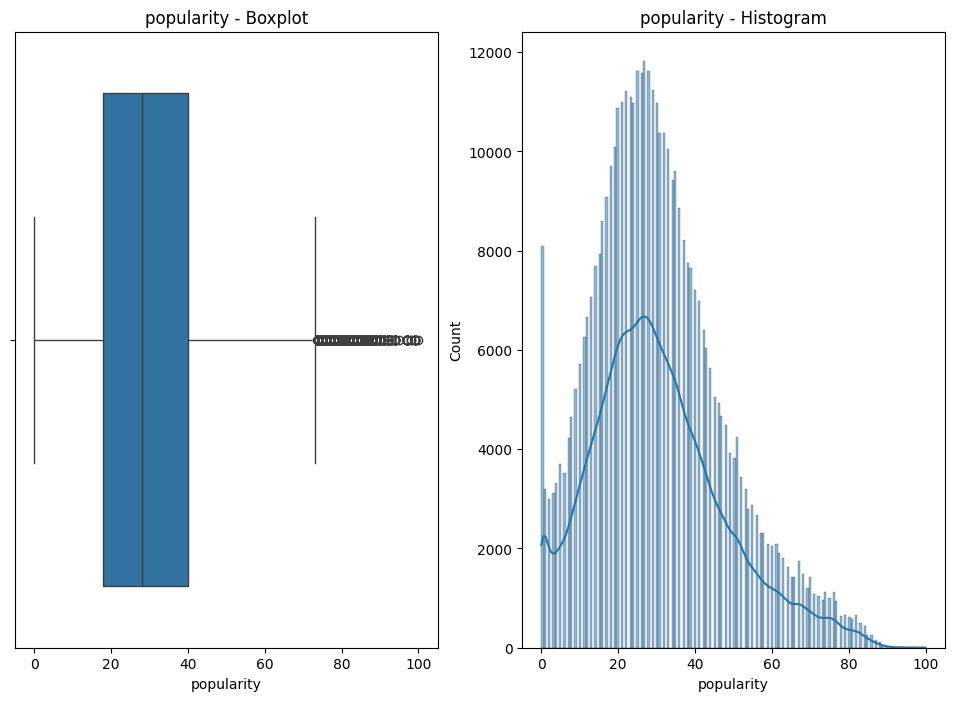

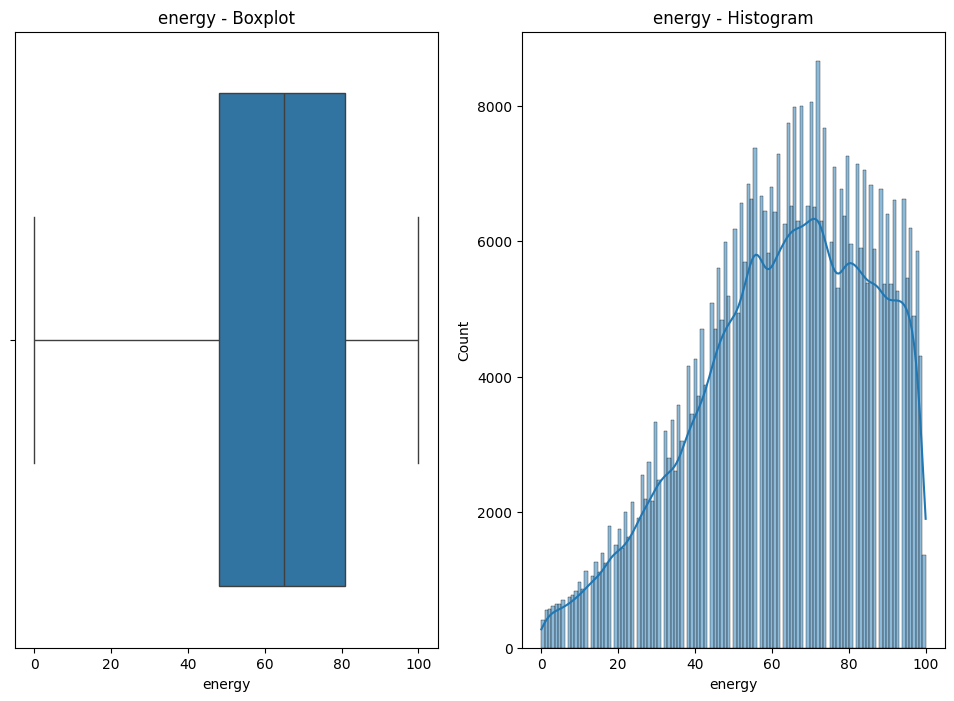

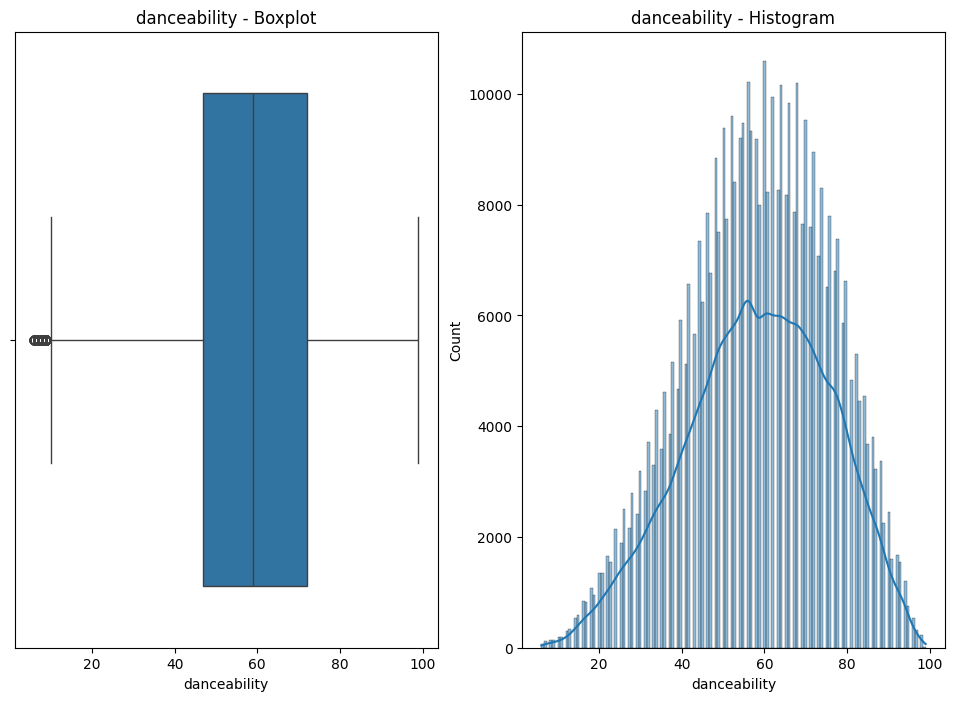

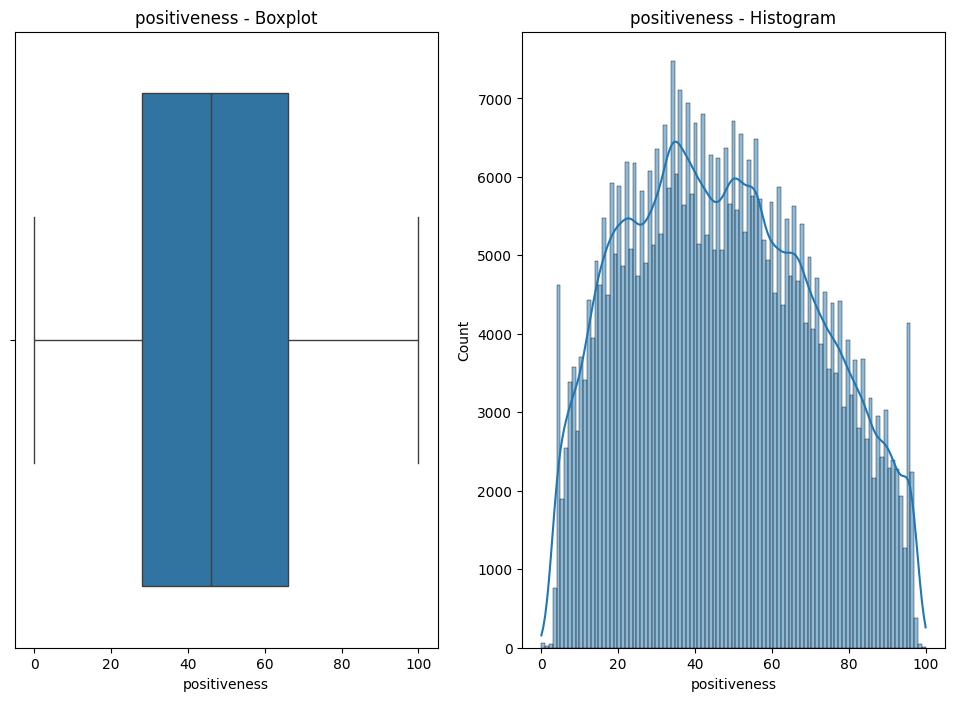

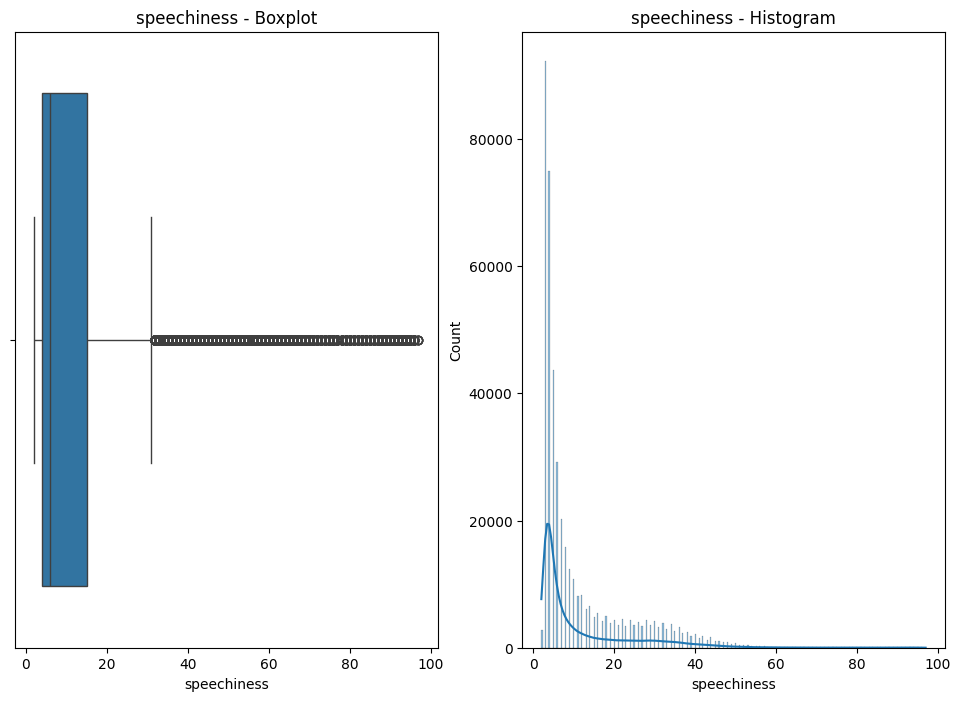

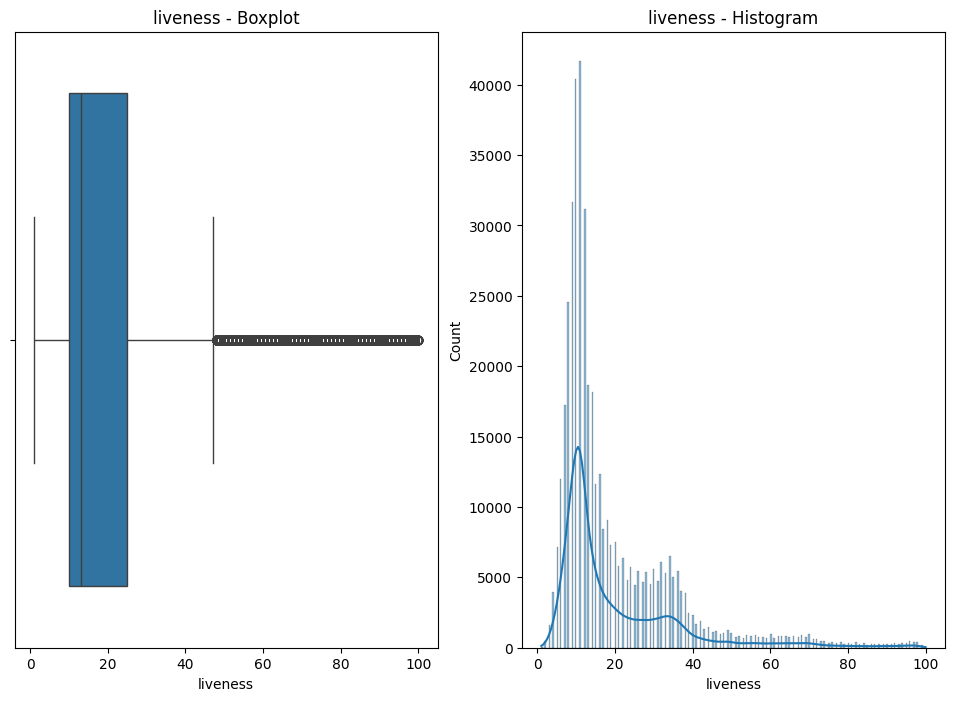

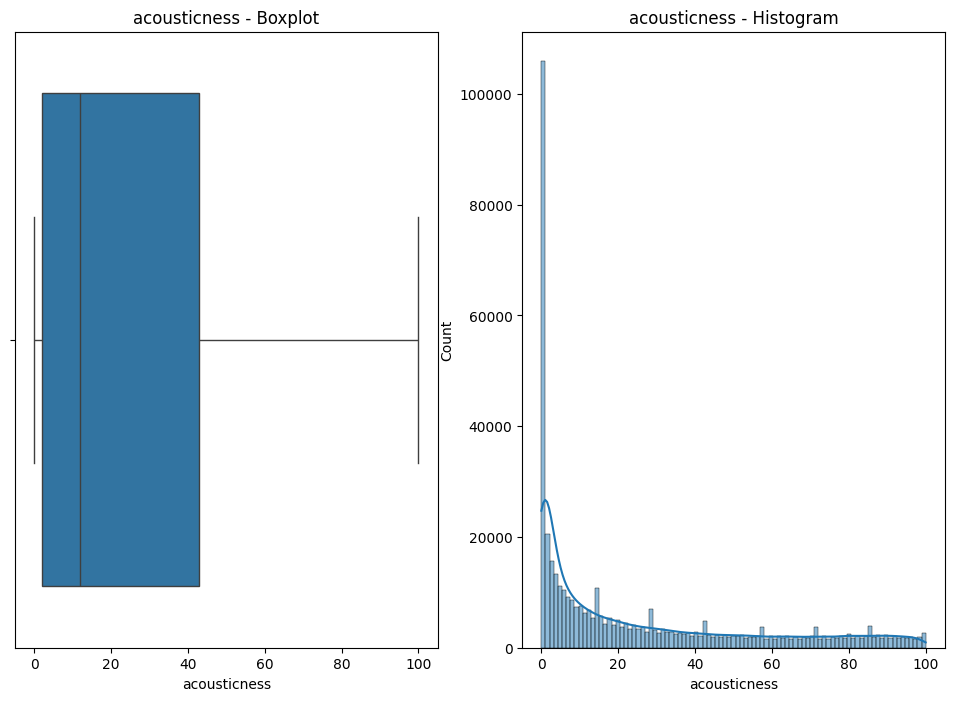

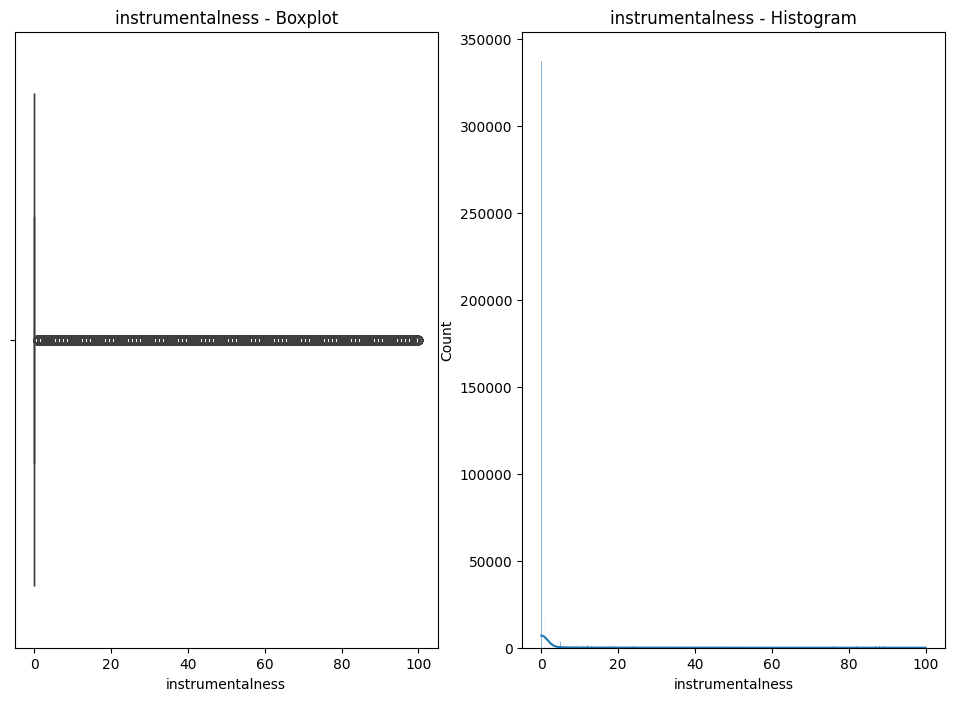

tempo: 881 outliers
loudness_db: 14938 outliers
popularity: 9250 outliers
energy: 0 outliers
danceability: 457 outliers
positiveness: 0 outliers
speechiness: 41936 outliers
liveness: 29885 outliers
acousticness: 0 outliers
instrumentalness: 105815 outliers
Sampled dataset size: (150000, 16)
emotion
anger      50000
joy        50000
sadness    50000
Name: count, dtype: int64
Dataframe after merging VADER: (150000, 20)


,vader_neg,vader_neu,vader_pos,vader_compound
count,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.112399,0.757946,0.129657,0.080878
std,0.077084,0.094522,0.078142,0.900272
min,0.000000,0.000000,0.000000,-1.000000
25%,0.055000,0.701000,0.077000,-0.968600
50%,0.100000,0.763000,0.115000,0.527550
75%,0.155000,0.822000,0.166000,0.979300
max,0.945000,1.000000,1.000000,1.000000


Emotion mapping (label : emotion):
{np.int64(0): 'anger', np.int64(1): 'joy', np.int64(2): 'sadness'}
After extracting first genre: 88 unique values
Dataframe after encoding:



,text,emotion,tempo,loudness_db,explicit,popularity,energy,danceability,positiveness,speechiness,...,key_F# Maj,key_F# min,key_G Maj,key_G min,key_G# Maj,key_G# min,ts_1/4,ts_3/4,ts_4/4,ts_5/4
0,"[Hook] I'm on that sand, man Sandman, I'm on t...",anger,142.0,-12.16,0,52,26,39,88,6,...,False,False,False,False,False,False,False,True,False,False
1,[Chorus: Gotye (Sampled)] Your heart's a mess ...,anger,128.0,-16.83,0,39,20,92,78,10,...,False,False,False,False,False,False,False,False,True,False
2,"[Chorus] Had to shoot your mans, I had no opti...",anger,146.0,-10.68,1,16,61,81,86,20,...,False,False,False,False,False,False,False,False,True,False
3,[Intro: sample (P.R. Terrorist)] For security ...,anger,91.0,-7.40,1,22,58,62,64,30,...,False,True,False,False,False,False,False,False,True,False
4,[Intro] (M3nace) (Senseii) [Chorus] Two in a ...,anger,142.0,-8.41,1,25,60,90,51,41,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,[Verse 1] Waiting for the morning sun Are you ...,sadness,91.0,-7.27,0,38,60,64,16,3,...,True,False,False,False,False,False,False,False,True,False
149996,Rows of houses all bearing down on me I can...,sadness,136.0,-20.14,0,16,7,27,5,4,...,False,False,False,False,False,False,False,False,True,False
149997,It's a shame you have a mind of your own now. ...,sadness,128.0,-8.16,0,23,87,41,34,6,...,False,False,False,False,False,False,False,False,True,False
149998,With a little bit of common sense You can lose...,sadness,177.0,-5.01,1,26,97,31,76,6,...,False,False,False,False,False,False,False,False,True,False


Dataframe after adding BERT embeddings:(149999, 91)
Final dataset after cleaning, preprocessing, and feature selection:
Columns present:

Index(['loudness_db', 'explicit', 'energy', 'danceability', 'positiveness',
       'speechiness', 'acousticness', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'genre_hip hop', 'ts_4/4', 'happy', 'sad',
       'bert_pca_1', 'bert_pca_2', 'bert_pca_3', 'bert_pca_4', 'bert_pca_5',
       'bert_pca_6', 'bert_pca_7', 'bert_pca_8', 'bert_pca_9', 'bert_pca_10'],
      dtype='object')
Number of columns:

25
X - features:



,loudness_db,explicit,energy,danceability,positiveness,speechiness,acousticness,vader_neg,vader_neu,vader_pos,...,bert_pca_1,bert_pca_2,bert_pca_3,bert_pca_4,bert_pca_5,bert_pca_6,bert_pca_7,bert_pca_8,bert_pca_9,bert_pca_10
0,-1.120729,1.0,-0.59375,0.40,-1.000000,0.076923,1.564103,1.11,-0.338843,-0.550562,...,-6.245886,-2.707624,-1.205121,-3.593364,-0.136110,-0.881039,1.242487,-0.039742,0.028815,0.028626
1,-0.193622,0.0,-0.34375,-0.16,-0.552632,-0.230769,1.179487,0.47,0.173554,-0.539326,...,-2.839111,-2.945980,2.982214,-3.970157,-0.004715,-0.558644,-1.666102,0.021519,-0.415252,0.331187
2,0.207289,0.0,0.59375,0.56,0.394737,-0.153846,-0.307692,-0.23,0.041322,0.438202,...,-5.410363,-2.982716,-0.261083,-3.705666,-0.785904,-0.156617,-1.298286,0.133035,0.454644,0.049422
3,-0.186788,0.0,0.31250,0.48,0.263158,0.538462,-0.179487,0.69,-0.247934,-0.202247,...,-6.518617,-4.049527,-1.155765,-4.311632,-0.158540,-0.874621,0.280072,-0.025625,0.001325,-0.105590
4,-0.640091,0.0,0.93750,-1.36,-1.052632,0.230769,-0.307692,0.58,0.396694,-0.955056,...,45.707345,-3.394455,5.048477,-2.610808,0.015258,-0.287261,0.423977,0.013145,-0.051301,0.036507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119994,0.175399,1.0,0.71875,-0.28,-0.026316,3.076923,0.051282,0.01,0.231405,-0.089888,...,1.811055,-1.941191,1.861807,-3.674033,-0.037448,-0.268699,-1.240944,-0.047760,-0.133034,-0.145482
119995,0.072893,0.0,-0.09375,0.24,0.473684,-0.153846,0.923077,0.73,-0.338843,-0.123596,...,-5.624153,5.080736,-1.273430,-3.966126,-0.112961,-0.883643,0.683563,-0.046635,0.006630,-0.030573
119996,-0.421412,0.0,0.40625,-0.04,0.684211,0.307692,-0.153846,-0.28,0.495868,-0.123596,...,-3.488500,-2.795932,-0.630876,2.480652,0.056020,1.629153,-0.317679,0.035871,-0.088843,0.004587
119997,0.519362,1.0,0.46875,0.48,0.131579,2.153846,0.256410,0.32,-0.049587,-0.056180,...,-6.340835,-4.021007,-1.386364,5.079936,0.084303,-0.102334,1.090765,-0.017870,0.032210,0.023751


Y - target:



0         0
1         0
2         0
3         0
4         0
         ..
149994    2
149995    2
149996    2
149997    2
149998    2
Name: emotion_label, Length: 149999, dtype: int64

In [3]:
from pyexpat import model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

#Convert to dataframes
df_json1 = pd.DataFrame(data_json1)
df_json2 = pd.DataFrame(data_json2)

#Standardize column names
def clean_col(df):
    df.columns = (df.columns.
                  str.strip().
                  str.lower().
                  str.replace(" ", "_").
                  str.replace("(", "").
                  str.replace(")", "").
                  str.replace("/", "_")
    )
    return df

df_csv = clean_col(df_csv)
df_json1 = clean_col(df_json1)
df_json2 = clean_col(df_json2)

#Columns that all 3 share and will be used for regression
common_cols = [
    "text", "emotion", "genre", "key", "tempo", "loudness_db", "time_signature", "explicit", "popularity", "energy", "danceability", 
    "positiveness", "speechiness", "liveness", "acousticness", "instrumentalness"
]

#Keep only available columns
df_csv = df_csv[[c for c in common_cols if c in df_csv.columns]]
df_json1 = df_json1[[c for c in common_cols if c in df_json1.columns]]
df_json2 = df_json2[[c for c in common_cols if c in df_json2.columns]]

#Merge the three datasets
df = pd.concat([df_csv, df_json1, df_json2], ignore_index=True)
print(f"Merged dataset size: {df.shape}")

df = df.drop_duplicates(subset=["text"])
df = df[df["text"].notna() & (df["text"].str.len() > 20)]  #Min length
df = df[df["text"].str.split().str.len() >= 15]  #More words required

#Clean numeric columns and convert types
numeric_cols = [
    "tempo", "loudness_db", "popularity", "energy", "danceability", "positiveness", "speechiness", "liveness", "acousticness", "instrumentalness"
]

#Keep only the db value, remove unit
if "loudness_db" in df.columns:
    df["loudness_db"] = (
        df["loudness_db"]
        .astype(str)            
        .str.replace("db", "")  #remove 'db'
        .str.strip()            #remove extra spaces
    )
    df["loudness_db"] = pd.to_numeric(df["loudness_db"], errors="coerce")

#Convert all the columns into numeric
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

#Map explicit to 1 or 0
df["explicit"] = df["explicit"].map({"Yes": 1, "No": 0})
df["explicit"] = df["explicit"].fillna(0)

#Drop rows missing emotion label - target
df = df[df["emotion"].notna()]
# Normalize emotion labels
df['emotion'] = df['emotion'].str.lower().str.strip()
#Keep only joy, sadness, anger
keep_emotions = ['joy', 'sadness', 'anger']
df = df[df['emotion'].isin(keep_emotions)]
print(df['emotion'].value_counts())


#Drop rows missing >30% numeric features
df.dropna(subset=numeric_cols, thresh=8, inplace=True)

#Fill missing values with median
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())
        # df[col].fillna(df[col].median(), inplace=True)

print("After cleaning:")
display(df.head())
#Data exploration
display(df.describe())
print(df["emotion"].value_counts())
print(df["genre"].value_counts().head(20))


#Emotion Distribution
plt.figure(figsize=(12,8))
sns.countplot(data=df, x="emotion", order=df["emotion"].value_counts().index)
plt.title("Emotion Distribution")
plt.show()

#Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), annot=True)
plt.title("Correlation Heatmap")
plt.show()

for col in numeric_cols:
    plt.figure(figsize=(12,8))
    
    #Boxplot
    plt.subplot(1,2,1)
    sns.boxplot(x=df[col])
    plt.title(f"{col} - Boxplot")
    
    #Histogram
    plt.subplot(1,2,2)
    #https://seaborn.pydata.org/generated/seaborn.histplot.html
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} - Histogram")
    plt.show()

#Find and display outliers
def detect_outliers(col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df[(df[col] < lower) | (df[col] > upper)][col]

for col in numeric_cols:
    outliers = detect_outliers(col)
    print(f"{col}: {len(outliers)} outliers")
    df[col] = winsorize(df[col], limits=[0.01, 0.01])  


#Sample 150,000 rows, 50k from each emotion
#Using https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
TARGET_SIZE = 150000
SAMPLES_PER_EMOTION = 50000

df_sampled_list = []
for emotion, group in df.groupby("emotion"):
    df_sampled_list.append(group.sample(SAMPLES_PER_EMOTION, random_state=42)
)

df_sampled = pd.concat(df_sampled_list, ignore_index=True)
df_sampled = df_sampled.reset_index(drop=True)
print("Sampled dataset size:", df_sampled.shape)
print(df_sampled["emotion"].value_counts())


#Add vader results to dataframe for regression
vader_path = os.path.join('../data', 'vader_sentiment_150k.pkl')

if os.path.exists(vader_path):
    vader_df = pd.read_pickle(vader_path)
    df_sampled['original_index'] = df_sampled.index
    
    df_sampled = df_sampled.merge(vader_df, on='original_index', how='left')
    df_sampled = df_sampled.drop('original_index', axis=1)
    
    print(f"Dataframe after merging VADER: {df_sampled.shape}")
    display(df_sampled[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']].describe())
else:
    print("VADER pickle not found, running analysis")
    analyzer = SentimentIntensityAnalyzer()
    chunk_size = 5000  #Make higher if using good CPU
    output_dir = '../data'
    os.makedirs(output_dir, exist_ok=True)
    vader_pickle_path = os.path.join(output_dir, 'vader_sentiment_150k.pkl')
    vader_csv_path = os.path.join(output_dir, 'vader_sentiment_150k.csv')

    vader_chunks = []

    #TQDM to see progress of analysis
    for start in tqdm(range(0, len(df_sampled), chunk_size), desc="Processing VADER"):
        chunk = df_sampled.iloc[start:start+chunk_size].copy()
        chunk_scores = chunk['text'].apply(lambda x: pd.Series(analyzer.polarity_scores(str(x))))
        chunk_scores = chunk_scores.rename(columns={"neg":"vader_neg","neu":"vader_neu","pos":"vader_pos","compound":"vader_compound"})
        chunk_scores['original_index'] = range(start, start + len(chunk))
        vader_chunks.append(chunk_scores)

    vader_df = pd.concat(vader_chunks, ignore_index=True)
    vader_df.to_pickle(vader_pickle_path)
    vader_df.to_csv(vader_csv_path, index=False)

    print(f"VADER analysis saved to pickle: {vader_pickle_path}")
    print(f"VADER analysis saved to CSV: {vader_csv_path}")


#Encode categorical
#Emotion - label encoding
label_enc = LabelEncoder()
df_sampled["emotion_label"] = label_enc.fit_transform(df_sampled["emotion"])
emotion_mapping = dict(zip(label_enc.transform(label_enc.classes_), label_enc.classes_))
print("Emotion mapping (label : emotion):")
print(emotion_mapping)

#Genre - one hot
#Extract only the 1st genre if a song has multiple
df_sampled['genre'] = df_sampled['genre'].astype(str).str.split(',').str[0].str.strip()
df_sampled['genre'] = df_sampled['genre'].replace(['nan', 'None', ''], 'unknown')
print(f"After extracting first genre: {df_sampled['genre'].nunique()} unique values")
#Take top 10 genres to avoid too many features
top_genres = df_sampled['genre'].value_counts().head(10).index
df_sampled['genre_grouped'] = df_sampled['genre'].apply(lambda x: x if x in top_genres else 'other')
df_sampled = pd.get_dummies(df_sampled, columns=["genre_grouped"], prefix="genre")
df_sampled.drop(columns=["genre"], inplace=True)

#Key - 24 keys in dataset
#One hot encoding
df_sampled["key"] = df_sampled["key"].fillna("unknown").astype(str).str.strip()
df_sampled["key"] = df_sampled["key"].astype(str).str.strip()
df_sampled = pd.get_dummies(df_sampled, columns=["key"], prefix="key")

#Time sig
#One hot encoding
df_sampled["time_signature"] = df_sampled["time_signature"].astype(str)
invalid_ts = ['nan', 'None', '', 'unknown']
df_sampled = df_sampled[~df_sampled["time_signature"].isin(invalid_ts)]
df_sampled = pd.get_dummies(df_sampled, columns=["time_signature"], prefix="ts")

print("Dataframe after encoding:\n")
display(df_sampled)

#generate BERT 
#ran into issue with bert pverloading 
# resource learned from: https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation
#df_sampled["text"]=df_sampled["text"].astype(str)
#so no recompiling would be needed
goPath = os.path.join('../data', 'goemotions.pkl')

if os.path.exists(goPath):
    #already found the goemo path
    emotion_df = pd.read_pickle(goPath)

else:
    tokenizer=AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
    emotionModel=AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")
    emotionModel.eval()
    ##id we can switch to cuda because it goes faster
    print(f"GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  cuda:{i}: {torch.cuda.get_device_name(i)}")
    
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    emotionModel.to(device)
    def goEmotion(texts, batch=32):
        torch.backends.cudnn.benchmark = True
        result=[]
        total_batches = (len(texts) + batch - 1) // batch
        for i in range(0,len(texts),batch):
            batch_idx = i // batch
            batchResult=texts[i:i+batch]
            inputs=tokenizer(batchResult,return_tensors="pt", padding=True, truncation=True,max_length=96).to(device)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            ##were having an issue with time constraints and it not loading quickly so using this it doesnt track gradient memory-->making faster
            with torch.no_grad():
                outputs=emotionModel(**inputs)
            logits=outputs.logits
            probs=torch.sigmoid(logits).cpu().numpy()
            result.append(probs)

            if batch_idx % max(1, total_batches//100) == 0 or batch_idx == total_batches - 1:
                print(f"Progress: {batch_idx}/{total_batches} ({batch_idx/total_batches*100:.1f}%)")
                print(f"  RTX VRAM: {torch.cuda.memory_allocated(0)/1e9:.1f}GB")
        return np.vstack(result)
    #gets the emotions
    emotionProbability=goEmotion(df_sampled["text"].astype(str).tolist())
    #make the labels names
    emotionLabels=list(emotionModel.config.id2label.values())
    emotion_df = pd.DataFrame(
        emotionProbability,
        columns=emotionLabels
    )
    os.makedirs(os.path.dirname(goPath), exist_ok=True)
    emotion_df.to_pickle(goPath)

    #df_sampled.drop(columns=emotion_df.columns, inplace=True)

#make the emotions collide with what we have
go_map = {
    "happy":["pride","admiration","amusement","excitement","love","optimism","gratitude","relief","joy"],
    "sad":["disappointment","remorse","sadness","grief"],
    "anger":["anger","annoyance","disapproval","disgust"],
    "fear":["fear", "nervousness"],
    "surprise":["surprise"],
    "neutral":["neutral", "realization"]
}

for target_emotion,fine_labels in go_map.items():
    valid_labels =[label for label in fine_labels if label in emotion_df.columns]
    df_sampled[target_emotion] = emotion_df[valid_labels].sum(axis=1)

# merge GoEmotions into sampled dataset
df_sampled = pd.concat([df_sampled.reset_index(drop=True), emotion_df.reset_index(drop=True)],axis=1)
print(f"Dataframe after adding BERT embeddings:{df_sampled.shape}")

numeric_cols += ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']
feature_cols = [c for c in df_sampled.columns 
                if c not in ["emotion", "emotion_label", "text"]]
X = df_sampled[feature_cols]
X = X.fillna(0)
y = df_sampled["emotion_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_final = X_train.copy()
X_test_final = X_test.copy()

# feature engineering
numeric_features = numeric_cols + ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'] + list(go_map.keys())
numeric_features = [f for f in numeric_features if f in X_train_final.columns]

scaler = RobustScaler()
X_train_scaled = X_train_final.copy()
X_test_scaled = X_test_final.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train_scaled[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test_scaled[numeric_features])


bert_columns = list(emotion_df.columns) 
bert_columns = [c for c in bert_columns if c in X_train_scaled.columns]

pca_components = min(10, len(bert_columns))
pca = PCA(n_components=pca_components, random_state=42)

X_train_scaled_pca = X_train_scaled.copy()
X_test_scaled_pca = X_test_scaled.copy()

X_train_scaled_pca_bert = pca.fit_transform(X_train_scaled_pca[bert_columns])
X_test_scaled_pca_bert = pca.transform(X_test_scaled_pca[bert_columns])

for i in range(pca_components):
    X_train_scaled_pca[f'bert_pca_{i+1}'] = X_train_scaled_pca_bert[:, i]
    X_test_scaled_pca[f'bert_pca_{i+1}'] = X_test_scaled_pca_bert[:, i]

X_train_scaled_pca.drop(columns=bert_columns, inplace=True)
X_test_scaled_pca.drop(columns=bert_columns, inplace=True)

k_best = 25
selector = SelectKBest(score_func=mutual_info_classif, k=k_best)

X_train_final_selected = selector.fit_transform(X_train_scaled_pca, y_train)
X_test_final_selected = selector.transform(X_test_scaled_pca)

selected_feature_names = X_train_scaled_pca.columns[selector.get_support()]

X_train_final = pd.DataFrame(X_train_final_selected, columns=selected_feature_names)
X_test_final = pd.DataFrame(X_test_final_selected, columns=selected_feature_names)

print("Final dataset after cleaning, preprocessing, and feature selection:")
print("Columns present:\n")
print(X_train_final.columns)
print("Number of columns:\n")
print(X_train_final.shape[1])
print("X - features:\n")
display(X_train_final)
print("Y - target:\n")
display(y)

<h1>Model Evaluation Function</h1>

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import time
def train_test_evaluate(model, model_name = "", visualize = False, X_train = X_train_final, X_test = X_test_final, y_train = y_train, y_test = y_test):
    fit_start = time.time()
    model.fit(X_train, y_train)
    fit_end = time.time()
    y_pred = model.predict(X_test)
    pred_end = time.time()
    y_pred_train = model.predict(X_train)
    if(visualize):
        print(model_name, "Results")
        print(model_name, "Test Results")
        print("Training time: {:.3f} seconds".format(fit_end - fit_start))
        print("Prediction time: {:.3f} seconds".format(pred_end - fit_end))
        print("Total time taken: {:.3f} seconds".format(pred_end - fit_start))
        print(classification_report(y_test, y_pred))
        print(model_name, "Training Results")
        print(classification_report(y_train, y_pred_train))
        cm_rf = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=label_enc.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{model_name} Confusion Matrix")
        plt.show()

    return y_pred

<h1>Decision Tree Classifier</h1>

Base Decision Tree Classifier (Gini) Results
Base Decision Tree Classifier (Gini) Test Results
Training time: 3.372 seconds
Prediction time: 0.005 seconds
Total time taken: 3.377 seconds
              precision    recall  f1-score   support

           0       0.57      0.57      0.57     10000
           1       0.57      0.57      0.57     10000
           2       0.82      0.82      0.82     10000

    accuracy                           0.66     30000
   macro avg       0.66      0.66      0.66     30000
weighted avg       0.66      0.66      0.66     30000

Base Decision Tree Classifier (Gini) Training Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40000
           1       1.00      1.00      1.00     40000
           2       1.00      1.00      1.00     39999

    accuracy                           1.00    119999
   macro avg       1.00      1.00      1.00    119999
weighted avg       1.00      1.00      1.00    11999

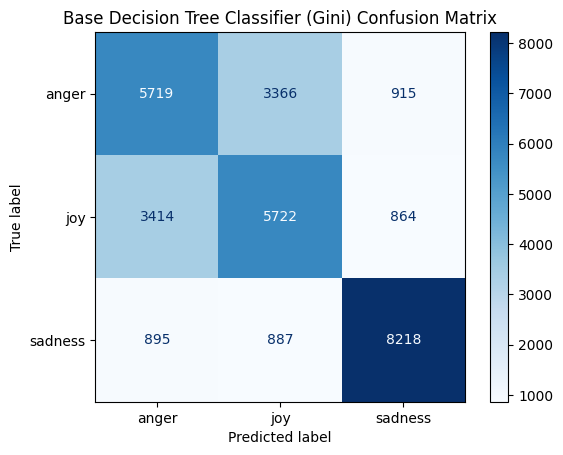

In [5]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Baseline Decision Tree - Gini
dt_base = DecisionTreeClassifier(random_state=42, criterion='gini')
y_pred_dt_base = train_test_evaluate(dt_base, visualize = True, model_name = "Base Decision Tree Classifier (Gini)")

Best parameters (single GridSearch):
{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best Decision Tree Classifier Results
Best Decision Tree Classifier Test Results
Training time: 1.622 seconds
Prediction time: 0.003 seconds
Total time taken: 1.624 seconds
              precision    recall  f1-score   support

           0       0.62      0.72      0.66     10000
           1       0.65      0.70      0.67     10000
           2       0.99      0.76      0.86     10000

    accuracy                           0.72     30000
   macro avg       0.75      0.72      0.73     30000
weighted avg       0.75      0.72      0.73     30000

Best Decision Tree Classifier Training Results
              precision    recall  f1-score   support

           0       0.62      0.72      0.67     40000
           1       0.65      0.70      0.68     40000
           2       1.00      0.77      0.87     39999

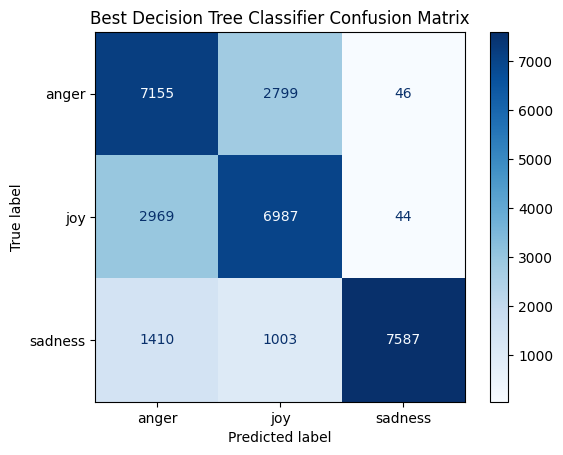

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1. Compact grid over reasonable params
param_grid = {
    'max_depth': [5, 10, None],         
    'min_samples_leaf': [1, 5],         
    'min_samples_split': [2, 5],        
    'ccp_alpha': [0.0, 0.01],           
    'criterion': ['gini'],              
    'max_features': [None, 'sqrt'],     
    'splitter': ['best'],               
}

dt_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
)

grid_search.fit(X_train_final, y_train)

print("Best parameters (single GridSearch):")
print(grid_search.best_params_)

# 2. Train best tree and evaluate
dt_clf_best = DecisionTreeClassifier(
    random_state=42,
    **grid_search.best_params_
)

y_pred_dt_best = train_test_evaluate(dt_clf_best, visualize = True, model_name = "Best Decision Tree Classifier")

<h1>Ensemble Methods</h1>

<h3>Random Forest</h3>

Base Random Forest Classifier Results
Base Random Forest Classifier Test Results
Training time: 3.890 seconds
Prediction time: 0.068 seconds
Total time taken: 3.959 seconds
              precision    recall  f1-score   support

           0       0.66      0.73      0.69     10000
           1       0.67      0.70      0.69     10000
           2       0.97      0.82      0.89     10000

    accuracy                           0.75     30000
   macro avg       0.77      0.75      0.76     30000
weighted avg       0.77      0.75      0.76     30000

Base Random Forest Classifier Training Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40000
           1       1.00      1.00      1.00     40000
           2       1.00      1.00      1.00     39999

    accuracy                           1.00    119999
   macro avg       1.00      1.00      1.00    119999
weighted avg       1.00      1.00      1.00    119999



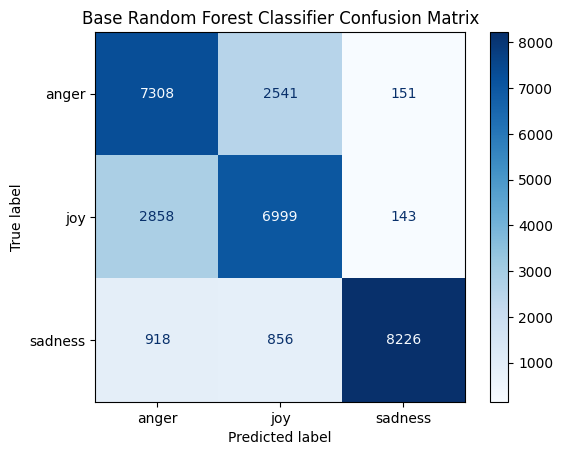

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

rf_base = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    n_jobs=-1
)

y_pred_rf_base = train_test_evaluate(rf_base, visualize = True, model_name = "Base Random Forest Classifier")

Best RF params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Best Random Forest Classifier (grid search) Results
Best Random Forest Classifier (grid search) Test Results
Training time: 42.631 seconds
Prediction time: 0.367 seconds
Total time taken: 42.998 seconds
              precision    recall  f1-score   support

           0       0.66      0.73      0.69     10000
           1       0.67      0.70      0.68     10000
           2       0.96      0.82      0.89     10000

    accuracy                           0.75     30000
   macro avg       0.77      0.75      0.76     30000
weighted avg       0.77      0.75      0.76     30000

Best Random Forest Classifier (grid search) Training Results
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     40000
           1       0.98      0.99      0.99     40000
           2       1.00      0.97      0.99  

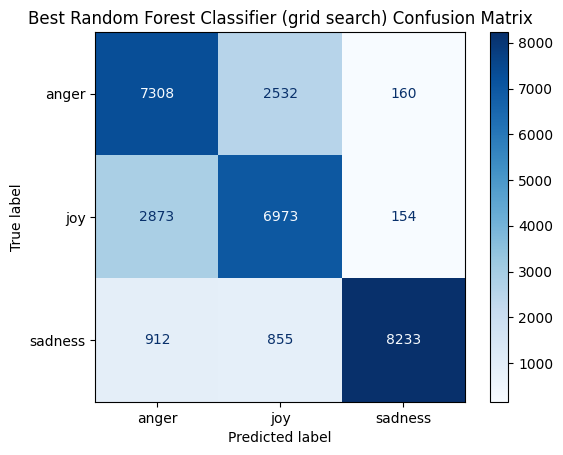

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Much cheaper random search over RF params
param_dist = {
    'n_estimators': [20, 40, 100],         
    'max_depth': [10, None],          
    'min_samples_split': [2, 5],      
    'min_samples_leaf': [1, 2],       
    'bootstrap': [True],              
    'max_features': ['sqrt'],         
}

rf_clf = RandomForestClassifier(random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist,
    n_iter=24,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train_final, y_train)
print("Best RF params:", rf_search.best_params_)

# Train and evluate best RF
rf_best = RandomForestClassifier(
    random_state=42,
    **rf_search.best_params_
)

y_pred_rf_grid = train_test_evaluate(rf_best, visualize = True, model_name = "Best Random Forest Classifier (grid search)")

Best Random Forest Classifier (random search) Results
Best Random Forest Classifier (random search) Test Results
Training time: 42.995 seconds
Prediction time: 0.364 seconds
Total time taken: 43.360 seconds
              precision    recall  f1-score   support

           0       0.66      0.73      0.69     10000
           1       0.67      0.70      0.68     10000
           2       0.96      0.82      0.89     10000

    accuracy                           0.75     30000
   macro avg       0.77      0.75      0.76     30000
weighted avg       0.77      0.75      0.76     30000

Best Random Forest Classifier (random search) Training Results
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     40000
           1       0.98      0.99      0.99     40000
           2       1.00      0.97      0.99     39999

    accuracy                           0.99    119999
   macro avg       0.99      0.99      0.99    119999
weighted avg       0.99

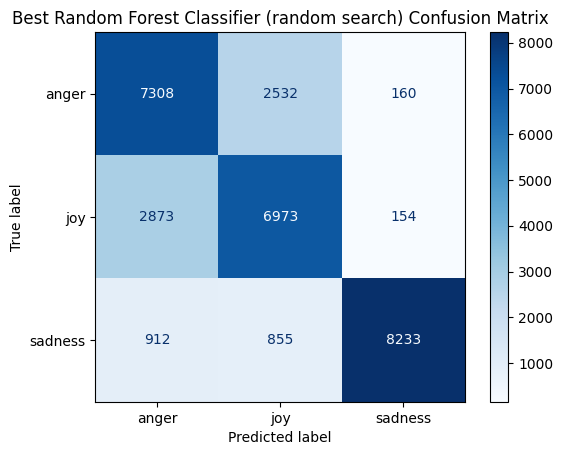

In [9]:
# Best Random Forest - Static Parameters

# Best parameters from Random Forest Random Search: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}
#Best parameters from Random Forest Stage 2 Random Search: {'max_features': 'sqrt', 'criterion': 'gini', 'class_weight': 'balanced'}
#Best parameters from Random Forest Stage 3 Random Search: {'min_weight_fraction_leaf': 0.0, 'min_impurity_decrease': 0.0}
#Best parameters from Random Forest Stage 4 Random Search: {'warm_start': True, 'oob_score': False}

rf_clf_best_random = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=1,
    max_depth=10,
    bootstrap=False,
    max_features='sqrt',
    criterion='gini',
    class_weight='balanced',
    min_weight_fraction_leaf=0.0,
    min_impurity_decrease=0.0,
    warm_start=True,
    oob_score=False,
    n_jobs=-1
)

y_pred_rf_random = train_test_evaluate(rf_best, visualize = True, model_name = "Best Random Forest Classifier (random search)")

<h3>AdaBoost</h3>

Base AdaBoost Ensemble Classifier Results
Base AdaBoost Ensemble Classifier Test Results
Training time: 17.240 seconds
Prediction time: 0.020 seconds
Total time taken: 17.260 seconds
              precision    recall  f1-score   support

           0       0.62      0.72      0.66     10000
           1       0.65      0.64      0.64     10000
           2       0.95      0.81      0.88     10000

    accuracy                           0.72     30000
   macro avg       0.74      0.72      0.73     30000
weighted avg       0.74      0.72      0.73     30000

Base AdaBoost Ensemble Classifier Training Results
              precision    recall  f1-score   support

           0       0.63      0.74      0.68     40000
           1       0.67      0.65      0.66     40000
           2       0.96      0.83      0.89     39999

    accuracy                           0.74    119999
   macro avg       0.75      0.74      0.74    119999
weighted avg       0.75      0.74      0.74    119999



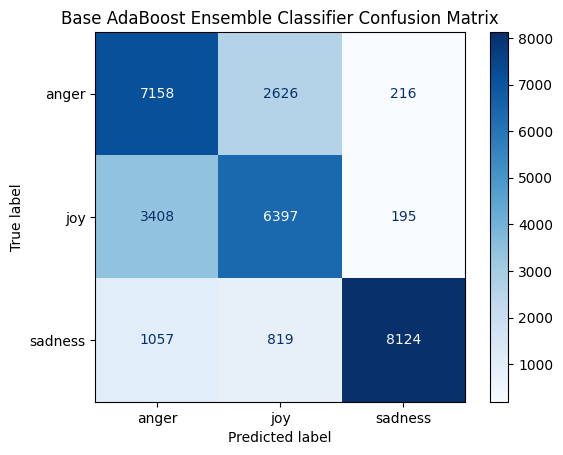

In [10]:
# AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier

#Best parameters DT (single GridSearch):
#{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
tuned_dt_clf = DecisionTreeClassifier(
    ccp_alpha=0.0,
    criterion='gini',
    max_depth=10,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2,
    splitter='best'
)

adb = AdaBoostClassifier(
    estimator=tuned_dt_clf,
    n_estimators=10,
    random_state=42
)

y_pred_adb = train_test_evaluate(adb, visualize = True, model_name = "Base AdaBoost Ensemble Classifier")

Best AdaBoost Params: {'n_estimators': 50, 'learning_rate': 0.1}
Best AdaBoost Classifier (Random Search) Results
Best AdaBoost Classifier (Random Search) Test Results
Training time: 10.797 seconds
Prediction time: 0.040 seconds
Total time taken: 10.838 seconds
              precision    recall  f1-score   support

           0       0.41      0.98      0.58     10000
           1       0.07      0.02      0.03     10000
           2       1.00      0.37      0.54     10000

    accuracy                           0.46     30000
   macro avg       0.49      0.46      0.38     30000
weighted avg       0.49      0.46      0.38     30000

Best AdaBoost Classifier (Random Search) Training Results
              precision    recall  f1-score   support

           0       0.41      0.98      0.58     40000
           1       0.08      0.02      0.03     40000
           2       1.00      0.37      0.54     39999

    accuracy                           0.46    119999
   macro avg       0.50    

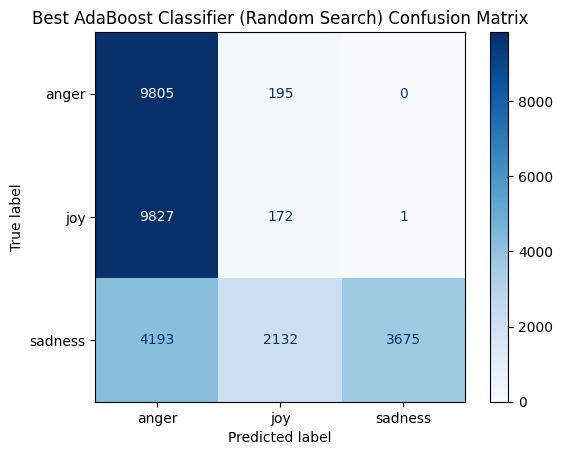

In [11]:
# AdaBoost Hyperparameter Tuning
param_dist = {
    'n_estimators': [20, 50],
    'learning_rate': [0.01, 0.1, 0.5],
}

adb_clf_random = AdaBoostClassifier(
    estimator=tuned_dt_clf,
    n_estimators=10,
    random_state=42
)

adb_random = RandomizedSearchCV(
    estimator=adb_clf_random,
    param_distributions=param_dist,
    n_iter=6,
    scoring='accuracy',
    cv=2,
    n_jobs=-1,
    random_state=42
)

adb_random.fit(X_train_final, y_train)
print("Best AdaBoost Params:", adb_random.best_params_)

# Train and evaluate best ADB
adb_best = AdaBoostClassifier(
    random_state=42,
    **adb_random.best_params_
)

y_pred_adb_random = train_test_evaluate(adb_best, visualize = True, model_name = "Best AdaBoost Classifier (Random Search)")

<h3>LightGBM</h3>

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4752
[LightGBM] [Info] Number of data points in the train set: 119999, number of used features: 25
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

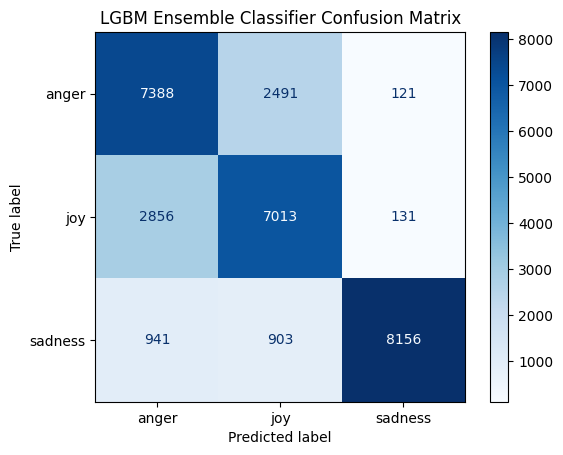

In [12]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

lgb= LGBMClassifier(
    objective="multiclass",
    n_estimators=200,
    learning_rate=0.03,
    num_leaves=20,
    max_depth=6,
    reg_alpha=0.1,
    reg_lambda=0.3,
    subsample=0.9,
    colsample_bytree=0.8,
    min_child_samples=20,
    class_weight="balanced",
    random_state=42
)

y_pred_adb = train_test_evaluate(lgb, visualize = True, model_name = "LGBM Ensemble Classifier")


<h3>XGBoost</h3>

Base XGBoost Ensemble Classifier Results
Base XGBoost Ensemble Classifier Test Results
Training time: 1.664 seconds
Prediction time: 0.051 seconds
Total time taken: 1.715 seconds
              precision    recall  f1-score   support

           0       0.66      0.74      0.70     10000
           1       0.68      0.70      0.69     10000
           2       0.97      0.82      0.89     10000

    accuracy                           0.76     30000
   macro avg       0.77      0.76      0.76     30000
weighted avg       0.77      0.76      0.76     30000

Base XGBoost Ensemble Classifier Training Results
              precision    recall  f1-score   support

           0       0.69      0.78      0.73     40000
           1       0.71      0.73      0.72     40000
           2       0.98      0.84      0.91     39999

    accuracy                           0.78    119999
   macro avg       0.80      0.78      0.79    119999
weighted avg       0.80      0.78      0.79    119999



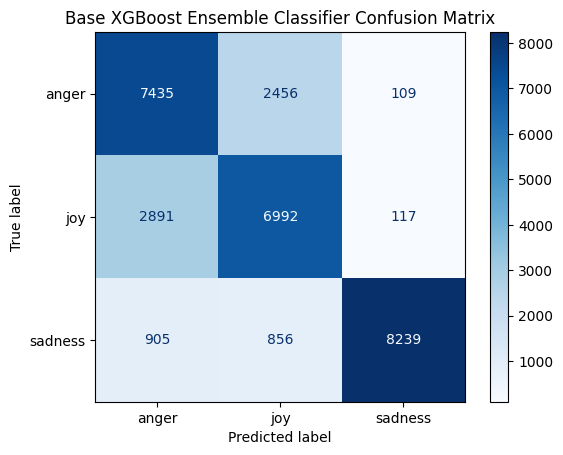

In [13]:
from xgboost import XGBClassifier

# Convert to numeric numpy arrays for XGBoost
X_train_xgb = X_train_final.astype('float32').to_numpy()
X_test_xgb  = X_test_final.astype('float32').to_numpy()

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(label_enc.classes_),
    tree_method="hist",
    random_state=42
)

y_pred_xgb = train_test_evaluate(xgb, visualize = True, model_name = "Base XGBoost Ensemble Classifier", X_train = X_train_xgb, X_test = X_test_xgb)

<h3>Stacking</h3>

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4752
[LightGBM] [Info] Number of data points in the train set: 95999, number of used features: 25
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Li

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking LightGBM and XGBoost Results
Stacking LightGBM and XGBoost Test Results
Training time: 43.076 seconds
Prediction time: 0.170 seconds
Total time taken: 43.247 seconds
              precision    recall  f1-score   support

           0       0.67      0.73      0.70     10000
           1       0.68      0.70      0.69     10000
           2       0.96      0.83      0.89     10000

    accuracy                           0.75     30000
   macro avg       0.77      0.75      0.76     30000
weighted avg       0.77      0.75      0.76     30000

Stacking LightGBM and XGBoost Training Results
              precision    recall  f1-score   support

           0       0.69      0.76      0.72     40000
           1       0.70      0.72      0.71     40000
           2       0.97      0.85      0.91     39999

    accuracy                           0.78    119999
   macro avg       0.79      0.78      0.78    119999
weighted avg       0.79      0.78      0.78    119999



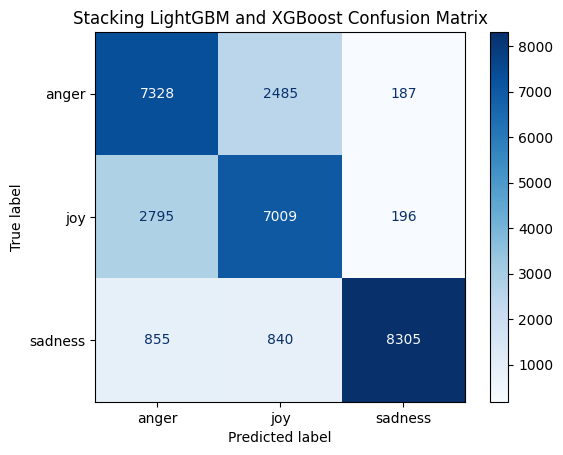

In [14]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
base= [
    ('xgb', XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=len(label_enc.classes_),
        tree_method="hist",
        random_state=42
    )),
    ('lgb', LGBMClassifier(
        objective="multiclass",
        n_estimators=200,
        learning_rate=0.03,
        num_leaves=20,
        max_depth=6,
        reg_alpha=0.1,
        reg_lambda=0.3,
        subsample=0.9,
        colsample_bytree=0.8,
        min_child_samples=20,
        class_weight="balanced",
        random_state=42
    ))
]

#use logistical reg as meta model
metaModel = LogisticRegression(multi_class='multinomial', max_iter=1000)
stackedModel = StackingClassifier(
    estimators=base,
    final_estimator=metaModel,
    cv=5,     
    n_jobs=-1,
    passthrough=True
)

#results
y_pred_stacked = train_test_evaluate(stackedModel,visualize=True,model_name="Stacking LightGBM and XGBoost",X_train=X_train_final,X_test=X_test_final)

<h3>Voting</h3>

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4752
[LightGBM] [Info] Number of data points in the train set: 119999, number of used features: 25
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

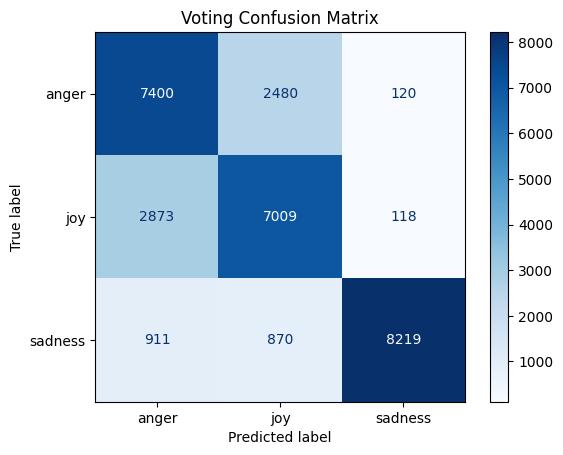

In [15]:
from sklearn.ensemble import VotingClassifier
voting=VotingClassifier(
    estimators=[('xgb',xgb), ('lgb',lgb)],
    voting='soft'
)
voting.fit(X_train_final, y_train)
y_pred_vote = train_test_evaluate(voting,visualize=True,model_name="Voting",X_train=X_train_final,X_test=X_test_final)

<h1>Support Vector Machines</h1>

<h3>SVM with linear kernel</h3>

SVM With Linear Kernel Results
SVM With Linear Kernel Test Results
Training time: 5.393 seconds
Prediction time: 0.002 seconds
Total time taken: 5.395 seconds
              precision    recall  f1-score   support

           0       0.58      0.61      0.59     10000
           1       0.56      0.64      0.60     10000
           2       0.65      0.51      0.57     10000

    accuracy                           0.59     30000
   macro avg       0.60      0.59      0.59     30000
weighted avg       0.60      0.59      0.59     30000

SVM With Linear Kernel Training Results
              precision    recall  f1-score   support

           0       0.58      0.61      0.59     40000
           1       0.55      0.64      0.59     40000
           2       0.65      0.51      0.57     39999

    accuracy                           0.59    119999
   macro avg       0.59      0.59      0.58    119999
weighted avg       0.59      0.59      0.58    119999



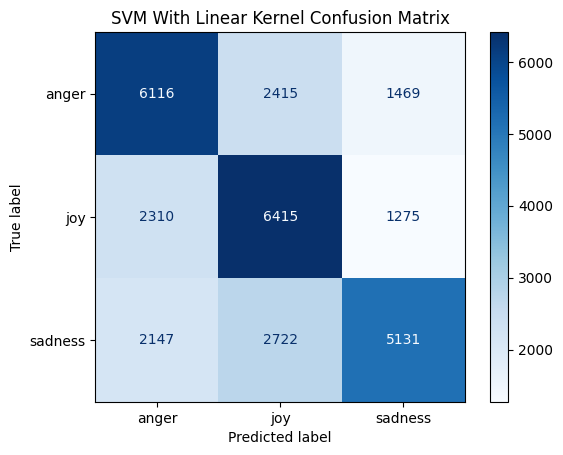

In [16]:
# Initial run with default hyperparameters
from sklearn.svm import LinearSVC
linear_svm = LinearSVC(random_state=42)
linear_svm_pred = train_test_evaluate(linear_svm, model_name="SVM With Linear Kernel", visualize=True)

Best parameters (single RandomSearch):
{'tol': 0.001, 'max_iter': 20000, 'loss': 'squared_hinge', 'fit_intercept': False, 'dual': False, 'C': 10}
Best Linear SVM Classifier (random search) Results
Best Linear SVM Classifier (random search) Test Results
Training time: 9.924 seconds
Prediction time: 0.002 seconds
Total time taken: 9.926 seconds
              precision    recall  f1-score   support

           0       0.58      0.61      0.59     10000
           1       0.56      0.64      0.60     10000
           2       0.65      0.51      0.57     10000

    accuracy                           0.59     30000
   macro avg       0.60      0.59      0.59     30000
weighted avg       0.60      0.59      0.59     30000

Best Linear SVM Classifier (random search) Training Results
              precision    recall  f1-score   support

           0       0.58      0.61      0.59     40000
           1       0.55      0.64      0.59     40000
           2       0.65      0.51      0.57     399

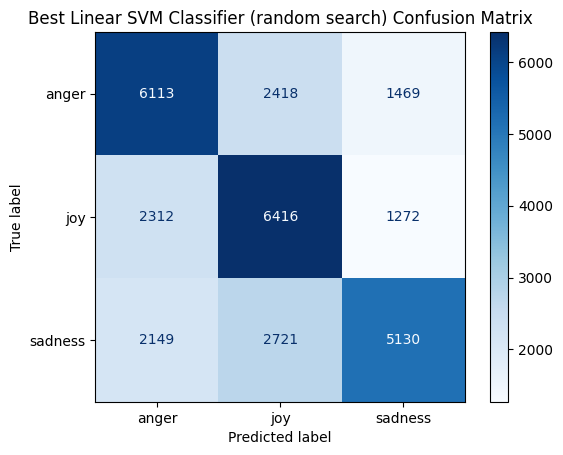

In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   
    'loss': ['squared_hinge'],  
    'dual': [False],               
    'tol': [1e-4, 1e-3, 1e-2], 
    'max_iter': [5000, 10000, 20000], 
    'fit_intercept': [True, False],
}

linear_svm = LinearSVC(random_state=42)

# random search
random_search = RandomizedSearchCV(
    estimator=linear_svm,
    param_distributions=param_grid,
    n_iter=20, 
    cv=3, 
    n_jobs=-1,  
    random_state=42
)

random_search.fit(X_train_final, y_train)

print("Best parameters (single RandomSearch):")
print(random_search.best_params_)

linear_svm_random_best = LinearSVC(
    random_state=42,
    **random_search.best_params_
)

y_pred_linear_svm_random_best = train_test_evaluate(linear_svm_random_best, visualize = True, model_name = "Best Linear SVM Classifier (random search)")

<h3>SVM with RBF kernel</h3>

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM With RBF Kernel Results
SVM With RBF Kernel Test Results
Training time: 13.483 seconds
Prediction time: 4.592 seconds
Total time taken: 18.076 seconds
              precision    recall  f1-score   support

           0       0.39      0.11      0.17     10000
           1       0.00      0.00      0.00     10000
           2       0.33      0.89      0.48     10000

    accuracy                           0.33     30000
   macro avg       0.24      0.33      0.22     30000
weighted avg       0.24      0.33      0.22     30000

SVM With RBF Kernel Training Results
              precision    recall  f1-score   support

           0       0.40      0.11      0.18     40000
           1       0.00      0.00      0.00     40000
           2       0.33      0.89      0.48     39999

    accuracy                           0.33    119999
   macro avg       0.24      0.33      0.22    119999
weighted avg       0.24      0.33      0.22    119999



/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


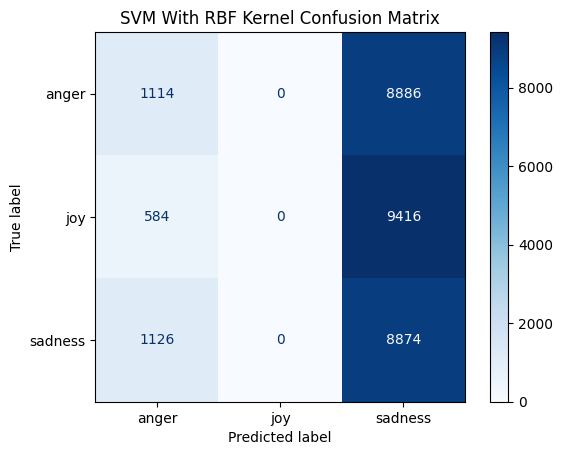

In [18]:
# Initial run with default hyperparameters
from sklearn.svm import SVC
# about 1k max iterations is as high as rbf SVM can go without taking too long
rbf_svm = SVC(kernel = "rbf", max_iter=1000)
rbf_svm_pred = train_test_evaluate(rbf_svm, model_name="SVM With RBF Kernel", visualize=True)

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

Best parameters (single RandomSearch):
{'tol': 0.001, 'shrinking': True, 'gamma': 0.1, 'C': 0.1}


/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best SVM with RBF Kernel Classifier (random search) Results
Best SVM with RBF Kernel Classifier (random search) Test Results
Training time: 13.650 seconds
Prediction time: 4.538 seconds
Total time taken: 18.188 seconds
              precision    recall  f1-score   support

           0       0.35      0.74      0.48     10000
           1       0.64      0.12      0.20     10000
           2       0.37      0.27      0.31     10000

    accuracy                           0.37     30000
   macro avg       0.45      0.37      0.33     30000
weighted avg       0.45      0.37      0.33     30000

Best SVM with RBF Kernel Classifier (random search) Training Results
              precision    recall  f1-score   support

           0       0.35      0.74      0.48     40000
           1       0.64      0.12      0.20     40000
           2       0.37      0.27      0.31     39999

    accuracy                           0.37    119999
   macro avg       0.45      0.37      0.33    119999
weigh

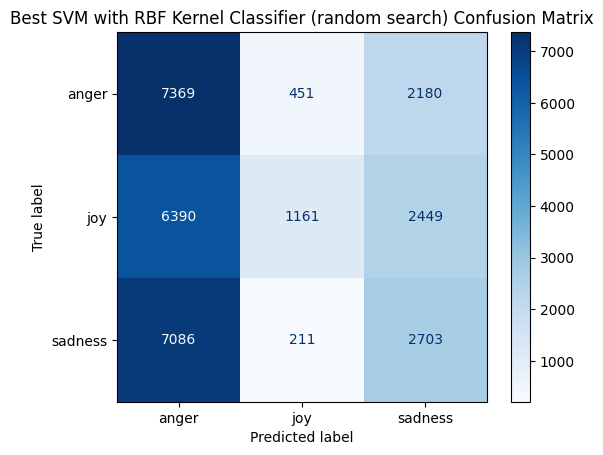

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],         
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],                    
    'shrinking': [True, False],             
    'tol': [1e-3, 1e-2, 1e-1],             
}

# trying with 1000 max iterations
rbf_svm = SVC(kernel = "rbf", max_iter=1000, random_state=42)

# random search
random_search = RandomizedSearchCV(
    estimator=rbf_svm,
    param_distributions=param_grid,
    n_iter=20, 
    cv=3, 
    n_jobs=-1,  
    random_state=42
)

random_search.fit(X_train_final, y_train)

print("Best parameters (single RandomSearch):")
print(random_search.best_params_)

rbf_svm_random_best = SVC(
    kernel="rbf",
    max_iter=1000,
    random_state=42,
    **random_search.best_params_
)

y_pred_rbf_svm_random_best = train_test_evaluate(rbf_svm_random_best, visualize = True, model_name = "Best SVM with RBF Kernel Classifier (random search)")

<h1>Logistic Regression</h1>

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


('Logistic Regression with C =', 0.25) Results
('Logistic Regression with C =', 0.25) Test Results
Training time: 4.995 seconds
Prediction time: 0.002 seconds
Total time taken: 4.997 seconds
              precision    recall  f1-score   support

           0       0.58      0.61      0.59     10000
           1       0.56      0.64      0.60     10000
           2       0.64      0.53      0.58     10000

    accuracy                           0.59     30000
   macro avg       0.60      0.59      0.59     30000
weighted avg       0.60      0.59      0.59     30000

('Logistic Regression with C =', 0.25) Training Results
              precision    recall  f1-score   support

           0       0.58      0.60      0.59     40000
           1       0.56      0.64      0.59     40000
           2       0.64      0.53      0.58     39999

    accuracy                           0.59    119999
   macro avg       0.59      0.59      0.59    119999
weighted avg       0.59      0.59      0.59   

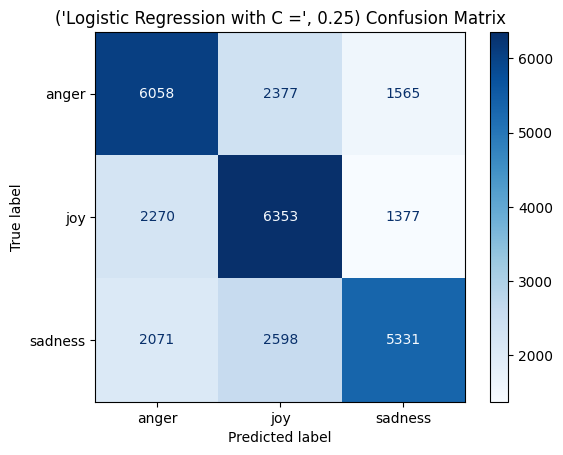

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


('Logistic Regression with C =', 0.5) Results
('Logistic Regression with C =', 0.5) Test Results
Training time: 4.736 seconds
Prediction time: 0.002 seconds
Total time taken: 4.738 seconds
              precision    recall  f1-score   support

           0       0.58      0.61      0.59     10000
           1       0.56      0.64      0.60     10000
           2       0.64      0.53      0.58     10000

    accuracy                           0.59     30000
   macro avg       0.60      0.59      0.59     30000
weighted avg       0.60      0.59      0.59     30000

('Logistic Regression with C =', 0.5) Training Results
              precision    recall  f1-score   support

           0       0.58      0.60      0.59     40000
           1       0.56      0.64      0.59     40000
           2       0.64      0.53      0.58     39999

    accuracy                           0.59    119999
   macro avg       0.59      0.59      0.59    119999
weighted avg       0.59      0.59      0.59    11

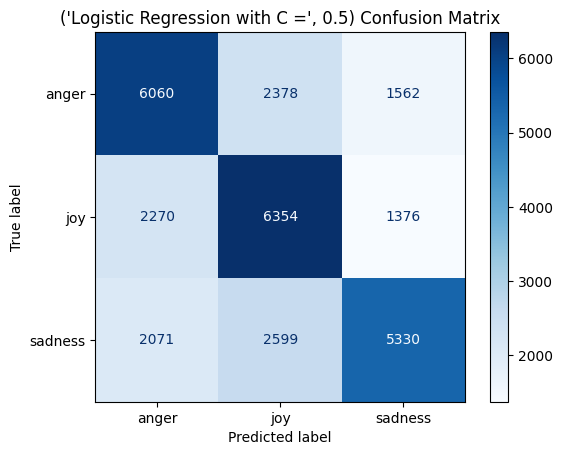

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


('Logistic Regression with C =', 0.75) Results
('Logistic Regression with C =', 0.75) Test Results
Training time: 4.482 seconds
Prediction time: 0.002 seconds
Total time taken: 4.484 seconds
              precision    recall  f1-score   support

           0       0.58      0.61      0.59     10000
           1       0.56      0.64      0.60     10000
           2       0.64      0.53      0.58     10000

    accuracy                           0.59     30000
   macro avg       0.60      0.59      0.59     30000
weighted avg       0.60      0.59      0.59     30000

('Logistic Regression with C =', 0.75) Training Results
              precision    recall  f1-score   support

           0       0.58      0.60      0.59     40000
           1       0.56      0.64      0.59     40000
           2       0.64      0.52      0.58     39999

    accuracy                           0.59    119999
   macro avg       0.59      0.59      0.59    119999
weighted avg       0.59      0.59      0.59   

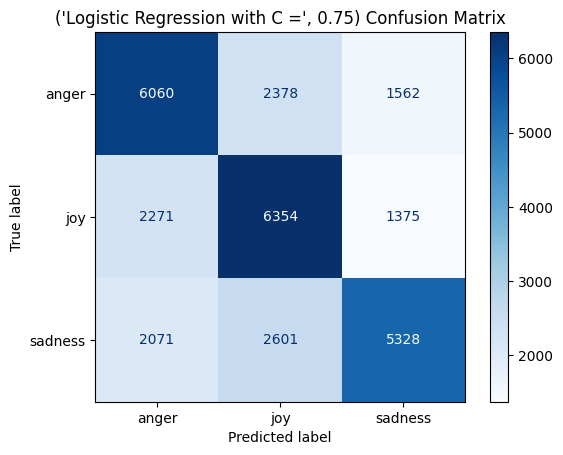

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


('Logistic Regression with C =', 1.0) Results
('Logistic Regression with C =', 1.0) Test Results
Training time: 4.963 seconds
Prediction time: 0.002 seconds
Total time taken: 4.965 seconds
              precision    recall  f1-score   support

           0       0.58      0.61      0.59     10000
           1       0.56      0.64      0.60     10000
           2       0.64      0.53      0.58     10000

    accuracy                           0.59     30000
   macro avg       0.60      0.59      0.59     30000
weighted avg       0.60      0.59      0.59     30000

('Logistic Regression with C =', 1.0) Training Results
              precision    recall  f1-score   support

           0       0.58      0.60      0.59     40000
           1       0.56      0.64      0.59     40000
           2       0.64      0.52      0.58     39999

    accuracy                           0.59    119999
   macro avg       0.59      0.59      0.59    119999
weighted avg       0.59      0.59      0.59    11

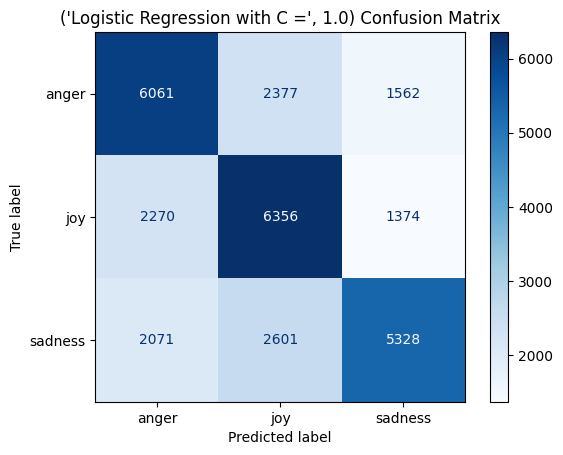

In [20]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Baseline Logistic Regression

for C in [0.25, 0.5, 0.75, 1.0]:
    logreg = LogisticRegression(
        multi_class='ovr',    
        solver='liblinear',
        max_iter=500,
        C=C,
        random_state=42,
    )
    y_pred_logreg = train_test_evaluate(logreg, model_name=("Logistic Regression with C =", C), visualize=True)

<h1>Polynomial Logistic Regression</h1>

Selected for polynomial LR: ['explicit', 'speechiness', 'vader_neg', 'vader_compound', 'happy', 'sad', 'bert_pca_1', 'bert_pca_3', 'bert_pca_4', 'bert_pca_5', 'bert_pca_6', 'bert_pca_7', 'bert_pca_8', 'bert_pca_9', 'bert_pca_10']
Original numeric dim: 25
Top-k dim: 15
Polynomial dim: 120


/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Polynomial Logistic Regression (top-k) Results
Polynomial Logistic Regression (top-k) Test Results
Training time: 22.468 seconds
Prediction time: 0.005 seconds
Total time taken: 22.473 seconds
              precision    recall  f1-score   support

           0       0.59      0.29      0.39     10000
           1       0.44      0.79      0.56     10000
           2       0.67      0.46      0.55     10000

    accuracy                           0.52     30000
   macro avg       0.57      0.52      0.50     30000
weighted avg       0.57      0.52      0.50     30000

Polynomial Logistic Regression (top-k) Training Results
              precision    recall  f1-score   support

           0       0.59      0.30      0.39     40000
           1       0.43      0.79      0.56     40000
           2       0.67      0.46      0.55     39999

    accuracy                           0.51    119999
   macro avg       0.57      0.51      0.50    119999
weighted avg       0.57      0.51      0.50 

/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


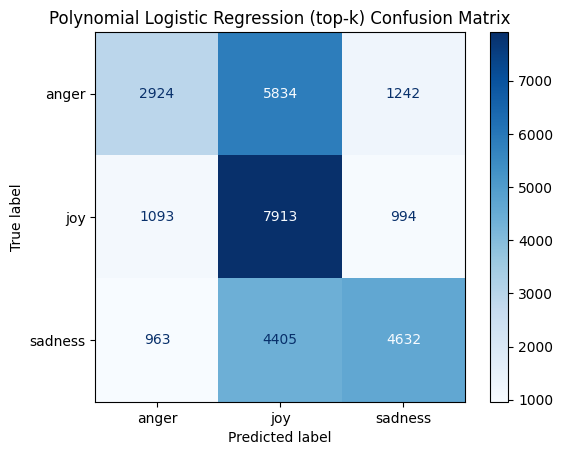

array([2, 0, 1, ..., 2, 1, 1], shape=(30000,))

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures

X_train_num = X_train_final.select_dtypes(include=[np.number])
X_test_num  = X_test_final.select_dtypes(include=[np.number])

# Top k numeric features (would take way too long otherwise)
k = 15
selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_train_top = selector.fit_transform(X_train_num, y_train)
X_test_top  = selector.transform(X_test_num)

selected_cols = X_train_num.columns[selector.get_support()]
print("Selected for polynomial LR:", list(selected_cols))

poly = PolynomialFeatures(
    degree=2,
    include_bias=False,
    interaction_only=True
)
X_train_poly = poly.fit_transform(X_train_top)
X_test_poly  = poly.transform(X_test_top)

print("Original numeric dim:", X_train_num.shape[1])
print("Top-k dim:", X_train_top.shape[1])
print("Polynomial dim:", X_train_poly.shape[1])

logreg_poly = LogisticRegression(
    multi_class='ovr',
    solver='saga',
    max_iter=200,
    C=0.5,
    random_state=42,
    n_jobs=-1
)

train_test_evaluate(model=logreg_poly, model_name="Polynomial Logistic Regression (top-k)", visualize=True, X_train=X_train_poly, X_test=X_test_poly)

<h1>Neural Network with Keras</h1>

2025-12-03 20:44:55.613611: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 20:44:55.648840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 20:44:56.363353: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/keras/src/lay

Epoch 1/30


2025-12-03 20:44:57.309352: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fa2640056b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-03 20:44:57.309363: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-12-03 20:44:57.318489: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-03 20:44:57.366978: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-03 20:44:57.378331: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:44:58.211358: 

140/211 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.5406 - loss: 1.0555

I0000 00:00:1764812698.952941   58725 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-12-03 20:44:59.169219: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:44:59.761732: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_236', 52 bytes spill stores, 52 bytes spill loads

2025-12-03 20:44:59.887885: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_236', 232 bytes spill stores, 232 bytes spill loads

2025-12-03 20:45:00.003477: I external/local

211/211 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6060 - loss: 0.8922 - val_accuracy: 0.6593 - val_loss: 0.7961
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6643 - loss: 0.7758 - val_accuracy: 0.6898 - val_loss: 0.7272
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.6918 - loss: 0.7167 - val_accuracy: 0.7102 - val_loss: 0.6800
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.7088 - loss: 0.6742 - val_accuracy: 0.7180 - val_loss: 0.6552
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7184 - loss: 0.6483 - val_accuracy: 0.7274 - val_loss: 0.6272
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.7252 - loss: 0.6299 - val_accuracy: 0.7324 - val_loss: 0.6161
Epoch 7/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.7286 - loss: 0.6210 - val_accuracy: 0.7393 - val_loss: 0.6039
Epoch 8/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.7316 - loss: 0.6126 - val_accuracy: 

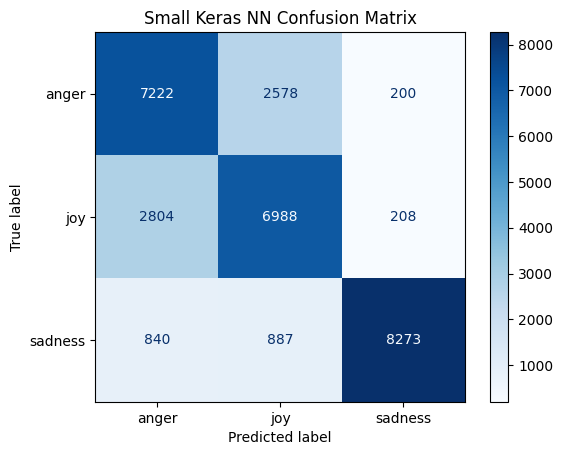

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf

# Small Shallow NN
num_features = X_train_final.shape[1]
num_classes = len(label_enc.classes_)

early_stop_small = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_small = Sequential([
    Dense(64, activation='relu', input_shape=(num_features,)),
    Dense(num_classes, activation='softmax')
])

model_small.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_small = model_small.fit(
    X_train_final, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=512,
    callbacks=[early_stop_small],
    verbose=1
)

y_proba_small = model_small.predict(X_test_final)
y_pred_small = np.argmax(y_proba_small, axis=1)

print("Small NN Classification Report:")
print(classification_report(y_test, y_pred_small, target_names=label_enc.classes_))

cm_small = confusion_matrix(y_test, y_pred_small)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_small, display_labels=label_enc.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Small Keras NN Confusion Matrix")
plt.show()


Epoch 1/30


/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-03 20:45:09.618088: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_140', 4 bytes spill stores, 4 bytes spill loads



208/211 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.6006 - loss: 0.9178

2025-12-03 20:45:10.632865: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_291', 8 bytes spill stores, 8 bytes spill loads



211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6013 - loss: 0.9163  

2025-12-03 20:45:11.630755: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 4 bytes spill stores, 4 bytes spill loads



211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6544 - loss: 0.8072 - val_accuracy: 0.7080 - val_loss: 0.6748
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.7199 - loss: 0.6477 - val_accuracy: 0.7321 - val_loss: 0.6150
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.7337 - loss: 0.6139 - val_accuracy: 0.7458 - val_loss: 0.5860
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7375 - loss: 0.6007 - val_accuracy: 0.7435 - val_loss: 0.5855
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.7426 - loss: 0.5900 - val_accuracy: 0.7508 - val_loss: 0.5747
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.7449 - loss: 0.5812 - val_accuracy: 0.7513 - val_loss: 0.5831
Epoch 7/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7472 - loss: 0.5779 - val_accuracy: 0.7506 - val_loss: 0.5765
Epoch 8/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7478 - loss: 0.5717 - val_accuracy: 0.758

2025-12-03 20:45:15.673901: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:45:15.881930: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 8 bytes spill stores, 8 bytes spill loads



938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 793us/step
Wide NN Classification Report:
              precision    recall  f1-score   support

       anger       0.66      0.74      0.70     10000
         joy       0.67      0.70      0.68     10000
     sadness       0.98      0.82      0.89     10000

    accuracy                           0.75     30000
   macro avg       0.77      0.75      0.76     30000
weighted avg       0.77      0.75      0.76     30000



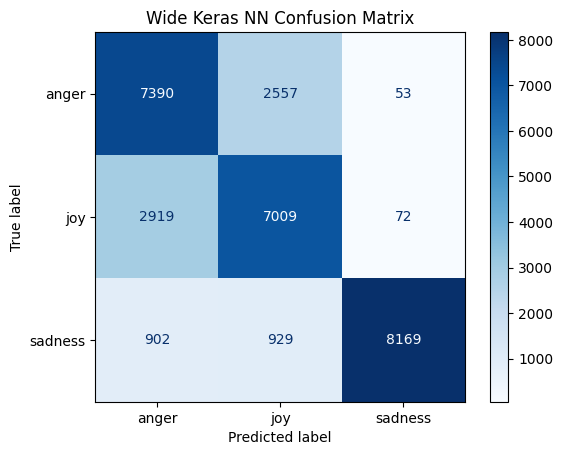

In [23]:
# Wide without Dropout

early_stop_wide = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_wide = Sequential([
    Dense(512, activation='relu', input_shape=(num_features,)),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_wide.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_wide = model_wide.fit(
    X_train_final, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=512,
    callbacks=[early_stop_wide],
    verbose=1
)

y_proba_wide = model_wide.predict(X_test_final)
y_pred_wide = np.argmax(y_proba_wide, axis=1)

print("Wide NN Classification Report:")
print(classification_report(y_test, y_pred_wide, target_names=label_enc.classes_))

cm_wide = confusion_matrix(y_test, y_pred_wide)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_wide, display_labels=label_enc.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Wide Keras NN Confusion Matrix")
plt.show()


Epoch 1/30


/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-03 20:45:18.029729: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:45:18.029749: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set 

199/211 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.4714 - loss: 1.5623

2025-12-03 20:45:20.445459: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:45:20.445479: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:45:21.129125: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1009', 52 bytes spill stores, 52 bytes spill loads

2025-12-03 20:45:21.166082: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5253 - loss: 1.2477 - val_accuracy: 0.6367 - val_loss: 0.8617
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.6106 - loss: 0.9068 - val_accuracy: 0.6712 - val_loss: 0.7783
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6546 - loss: 0.7991 - val_accuracy: 0.6972 - val_loss: 0.7068
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.6813 - loss: 0.7352 - val_accuracy: 0.7108 - val_loss: 0.6611
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.7001 - loss: 0.6913 - val_accuracy: 0.7226 - val_loss: 0.6315
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.7113 - loss: 0.6628 - val_accuracy: 0.7301 - val_loss: 0.6123
Epoch 7/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7182 - loss: 0.6452 - val_accuracy: 0.7340 - val_loss: 0.6008
Epoch 8/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7237 - loss: 0.6320 - val_accuracy: 0.73

2025-12-03 20:45:29.323816: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:45:29.501549: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 8 bytes spill stores, 8 bytes spill loads



931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step

2025-12-03 20:45:30.625516: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 8 bytes spill stores, 8 bytes spill loads

2025-12-03 20:45:30.676963: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 8 bytes spill stores, 8 bytes spill loads



938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 868us/step
Keras NN Classification Report:
              precision    recall  f1-score   support

       anger       0.64      0.75      0.69     10000
         joy       0.67      0.68      0.67     10000
     sadness       0.99      0.81      0.89     10000

    accuracy                           0.75     30000
   macro avg       0.77      0.75      0.75     30000
weighted avg       0.77      0.75      0.75     30000



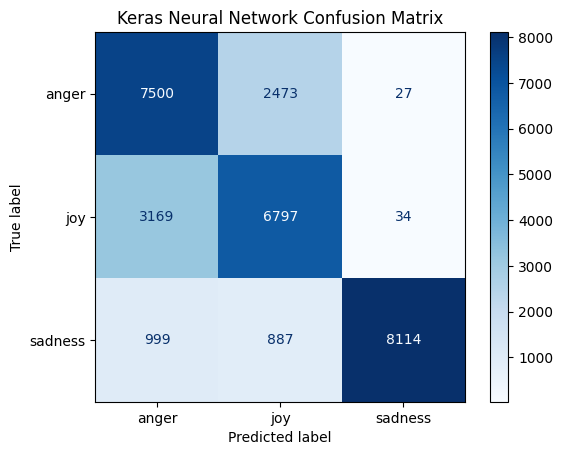

In [24]:
from tensorflow.keras.layers import Dropout

# Wide with Dropout (Regularized)

num_features = X_train_final.shape[1]
num_classes = len(label_enc.classes_)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model = Sequential([
    Dense(256, activation='relu', input_shape=(num_features,)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),  # slightly smaller LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_final, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=512,
    callbacks=[early_stop],
)

y_proba = model.predict(X_test_final)
y_pred_nn = np.argmax(y_proba, axis=1)

print("Keras NN Classification Report:")
print(classification_report(y_test, y_pred_nn, target_names=label_enc.classes_))

cm_nn = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=label_enc.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Keras Neural Network Confusion Matrix")
plt.show()

Epoch 1/30


/home/jack/Desktop/spotify-lyrical-analysis/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-03 20:45:31.686446: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:45:31.686476: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set 

145/211 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.5790 - loss: 0.9278

2025-12-03 20:45:33.525179: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:45:33.525211: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:45:33.980868: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_330', 16 bytes spill stores, 16 bytes spill loads

2025-12-03 20:45:34.044126: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5999 - loss: 0.8867 

2025-12-03 20:45:35.862467: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:45:35.862489: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:45:36.317718: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 8 bytes spill stores, 8 bytes spill loads

2025-12-03 20:45:36.391729: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6573 - loss: 0.7726 - val_accuracy: 0.7239 - val_loss: 0.6297
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7282 - loss: 0.6169 - val_accuracy: 0.7416 - val_loss: 0.5891
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7375 - loss: 0.5904 - val_accuracy: 0.7446 - val_loss: 0.5732
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7415 - loss: 0.5810 - val_accuracy: 0.7488 - val_loss: 0.5672
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.7446 - loss: 0.5741 - val_accuracy: 0.7535 - val_loss: 0.5585
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7457 - loss: 0.5692 - val_accuracy: 0.7522 - val_loss: 0.5599
Epoch 7/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7468 - loss: 0.5674 - val_accuracy: 0.7548 - val_loss: 0.5574
Epoch 8/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7485 - loss: 0.5640 - val_accuracy: 0.7558 -

2025-12-03 20:45:39.336889: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:45:39.336907: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:45:39.513832: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 8 bytes spill stores, 8 bytes spill loads

2025-12-03 20:45:39.971583: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

824/938 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step

2025-12-03 20:45:40.847347: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 8 bytes spill stores, 8 bytes spill loads



938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step
Bottleneck NN Classification Report:
              precision    recall  f1-score   support

       anger       0.66      0.74      0.70     10000
         joy       0.67      0.69      0.68     10000
     sadness       0.96      0.82      0.89     10000

    accuracy                           0.75     30000
   macro avg       0.76      0.75      0.75     30000
weighted avg       0.76      0.75      0.75     30000



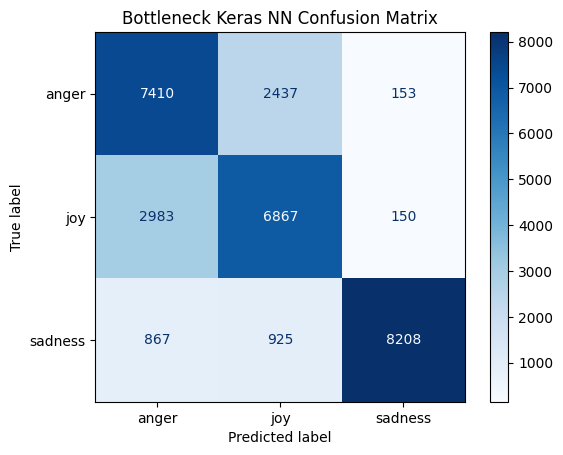

In [25]:
# Bottleneck

early_stop_bottle = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_bottle = Sequential([
    Dense(256, activation='relu', input_shape=(num_features,)),
    Dense(64, activation='relu'),       # bottleneck
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_bottle.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_bottle = model_bottle.fit(
    X_train_final, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=512,
    callbacks=[early_stop_bottle],
    verbose=1
)

y_proba_bottle = model_bottle.predict(X_test_final)
y_pred_bottle = np.argmax(y_proba_bottle, axis=1)

print("Bottleneck NN Classification Report:")
print(classification_report(y_test, y_pred_bottle, target_names=label_enc.classes_))

cm_bottle = confusion_matrix(y_test, y_pred_bottle)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bottle, display_labels=label_enc.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Bottleneck Keras NN Confusion Matrix")
plt.show()


<h1>KNN</h1>

Base KNN Classifier Results
Base KNN Classifier Test Results
Training time: 0.012 seconds
Prediction time: 2.499 seconds
Total time taken: 2.511 seconds
              precision    recall  f1-score   support

           0       0.56      0.69      0.62     10000
           1       0.58      0.61      0.60     10000
           2       0.92      0.66      0.77     10000

    accuracy                           0.65     30000
   macro avg       0.69      0.65      0.66     30000
weighted avg       0.69      0.65      0.66     30000

Base KNN Classifier Training Results
              precision    recall  f1-score   support

           0       0.66      0.81      0.73     40000
           1       0.70      0.72      0.71     40000
           2       0.96      0.72      0.82     39999

    accuracy                           0.75    119999
   macro avg       0.77      0.75      0.75    119999
weighted avg       0.77      0.75      0.75    119999



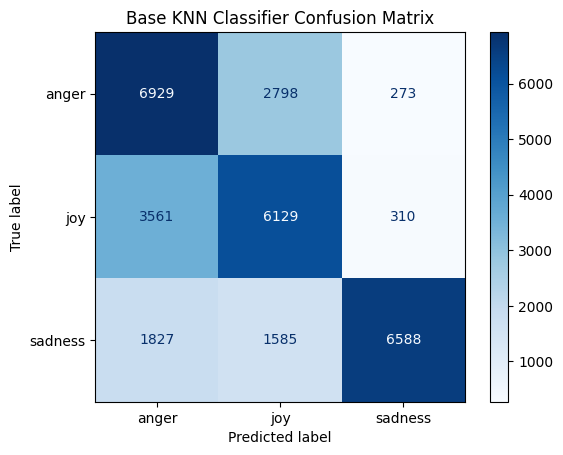

In [26]:
from sklearn.neighbors import KNeighborsClassifier
# run initial test with default hyperparameters
knn = KNeighborsClassifier(n_jobs=-1)
knn_pred = train_test_evaluate(knn, model_name="Base KNN Classifier", visualize=True)

Best parameters (single RandomSearch):
{'weights': 'distance', 'p': 2, 'n_neighbors': 21, 'metric': 'manhattan'}
Best KNN Classifier (random search) Results
Best KNN Classifier (random search) Test Results
Training time: 0.009 seconds
Prediction time: 7.360 seconds
Total time taken: 7.369 seconds
              precision    recall  f1-score   support

           0       0.61      0.71      0.66     10000
           1       0.60      0.68      0.64     10000
           2       0.94      0.67      0.79     10000

    accuracy                           0.69     30000
   macro avg       0.72      0.69      0.69     30000
weighted avg       0.72      0.69      0.69     30000

Best KNN Classifier (random search) Training Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40000
           1       1.00      1.00      1.00     40000
           2       1.00      1.00      1.00     39999

    accuracy                           1.00    119

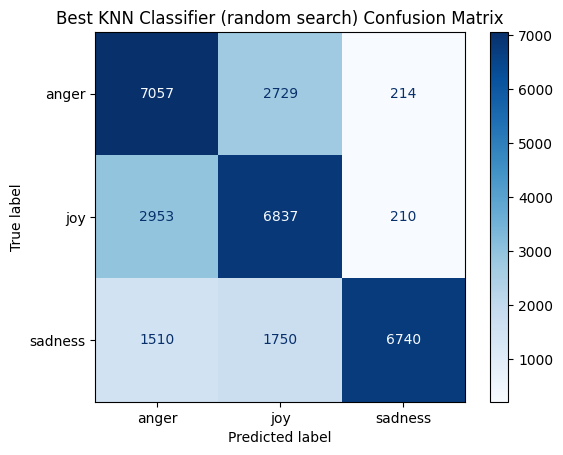

In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'n_neighbors': list(range(1, 31)),    
    'weights': ['uniform', 'distance'],      
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],  
    'p': [1, 2],                             
    #'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  
}

knn = KNeighborsClassifier(n_jobs=-1)

# random search
random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_grid,
    n_iter=20, 
    cv=3, 
    n_jobs=-1,  
    random_state=42
)

random_search.fit(X_train_final, y_train)

print("Best parameters (single RandomSearch):")
print(random_search.best_params_)

knn_best = KNeighborsClassifier(
    n_jobs=-1,
    **random_search.best_params_
)

y_pred_knn_random_best = train_test_evaluate(knn_best, visualize = True, model_name = "Best KNN Classifier (random search)")